In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import scipy.linalg as linalg
from scipy.linalg import ldl
import scipy.sparse.linalg
import scipy.sparse

import matplotlib.animation as animation
import matplotlib.cm as cm


%matplotlib notebook

<IPython.core.display.Javascript object>


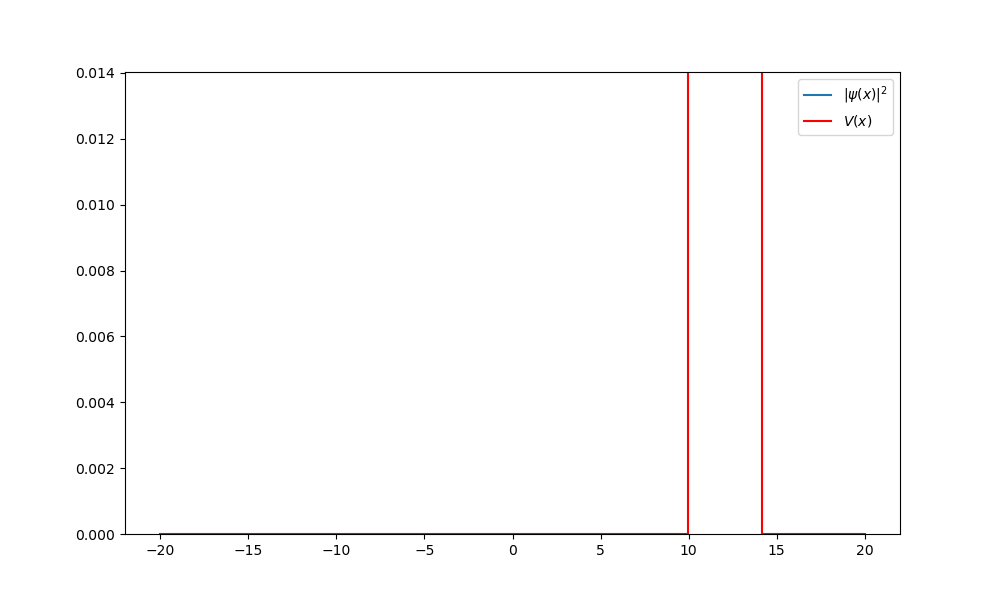

In [24]:
def V(x):
    #return -5*np.exp(-0.5*np.abs(x))+1/(np.abs(x)+0.01)
    #return np.zeros(len(x))+100
    V = np.zeros(Nx) 
    
    V[int(0.75*Nx):int(0.85*Nx)] =  35*np.square(0.25-x[int(0.75*Nx):int(0.85*Nx)])
    #return 35*np.square(0.5-x)
    return V

def update_V(dt, phi, x):
    return np.exp(-1j*dt*V(x))*phi

def update_T(dt, phi, x):
    N = len(x)
    k = np.linspace(-20,20,N)
    psi = np.fft.fft(phi)
    for i in range(0, len(psi)):
        psi[i] = np.exp(-1j*dt*(k[(i+int(0.5*N))%N])**2)*psi[i]
    phi = np.fft.ifft(psi)
    return phi


def solver(phi, x, N_max):
    N_x = len(x)
    
    psi = np.zeros((N_max, N_x), dtype=complex)
    psi1 = np.zeros((N_max, N_x), dtype=complex)
    
    r = np.zeros(N_max, dtype=complex)
    t = np.zeros(N_max, dtype = complex)
    
    dx = x[1]-x[0]
    dt = 0.01
    phi = update_V(dt/2., phi, x)
    phi = update_T(dt, phi, x)
    
    for i in range(N_max):
        phi = update_V(dt, phi, x)
        psi1[i]=phi
        phi = update_T(dt, phi, x)
         
        psi[i]=phi
        
        r[i] = phi[0]-1
        t[i] = phi[-1]
   
    phi = update_V(dt/2., phi, x)
    return psi, psi1

def animate(t):
    linePsi.set_ydata( (abs(psi[t])   )**2)
    return linePsi,


def init():
    linePsi.set_ydata(np.ma.array(x, mask=True))
    return linePsi,


 
x = np.linspace(-20,20,200)
dx = x[1]-x[0]
Nx = len(x)
x0 = 0
sigma = 0.05
gaussWidth=0.05
k=40
#phi0 = np.exp(-(x-x0)**2/(2*gaussWidth**2)) * np.exp(1j*x*k)#np.exp(-0.5*((x-x0)/sigma)**2+1j*x*k)
phi0 = np.exp(-0.5*((x-x0)/sigma)**2+1j*x*k)
#phi0 /= np.trapz(abs(phi0)**2, dx=dx)  
Nt = 250
psi, psi1 = solver(phi0,x,Nt)

 
fig, ax = plt.subplots(figsize=(10, 6))
linePsi, = ax.plot(x, abs(psi[0, :]  )**2, label='$|\psi(x)|^2$')
ani = animation.FuncAnimation(fig, animate, frames=Nt, init_func=init, interval=100, blit=True)

plt.ylim(0, 1.5*max(abs(psi[0])**2))
plt.plot(x, V(x), c='r', label='$V(x)$')
plt.legend(loc=0)


plt.show()



<IPython.core.display.Javascript object>


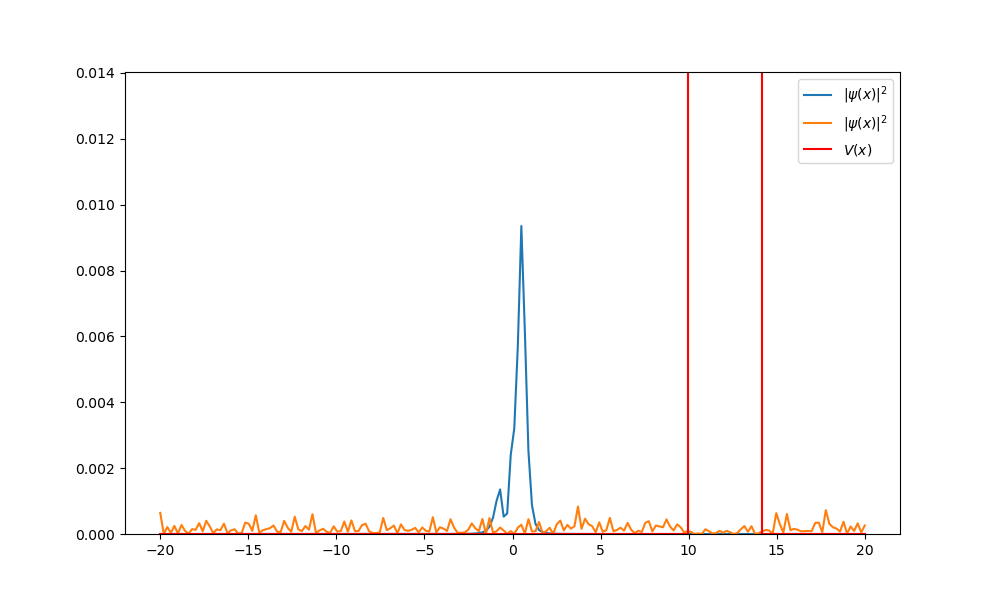

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
linePsi, = ax.plot(x, abs(psi[0, :]     )**2, label='$|\psi(x)|^2$')
linePsi, = ax.plot(x, abs(psi[-1, :]     )**2, label='$|\psi(x)|^2$')
plt.plot(x, V(x), c='r', label='$V(x)$')
plt.ylim(0, 1.5*max(abs(psi[0])**2))
plt.legend(loc=0)

#plt.show()

<IPython.core.display.Javascript object>


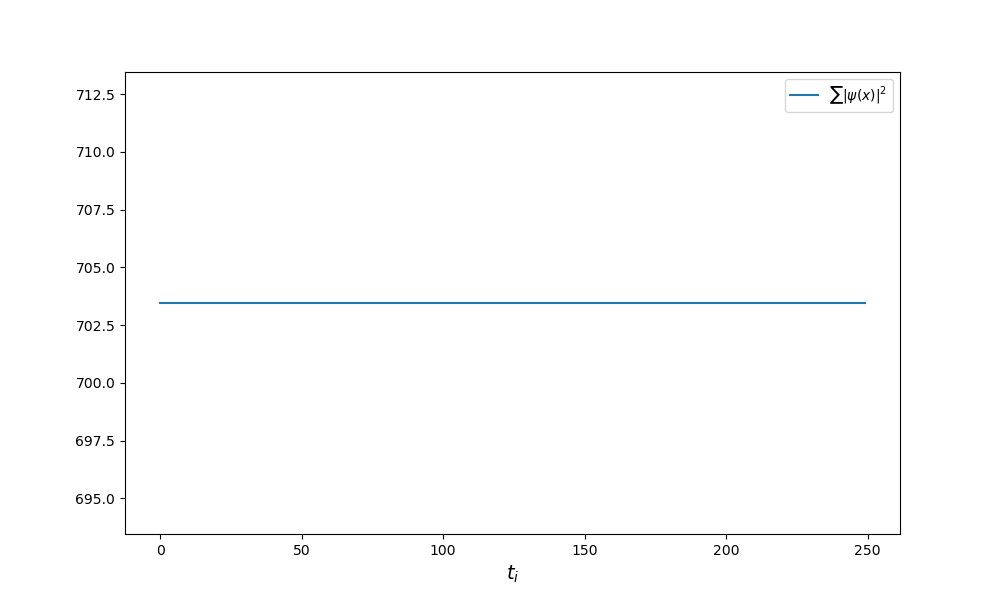

In [9]:
q = np.sum(np.square(np.abs(psi) ), axis = 1 )

fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(q, label = r'$ \sum |\psi(x)|^2$' )

plt.xlabel(r'$t_i$', fontsize = 14)
plt.ylim(q[0]-10, q[0]+10)

plt.legend()

<IPython.core.display.Javascript object>


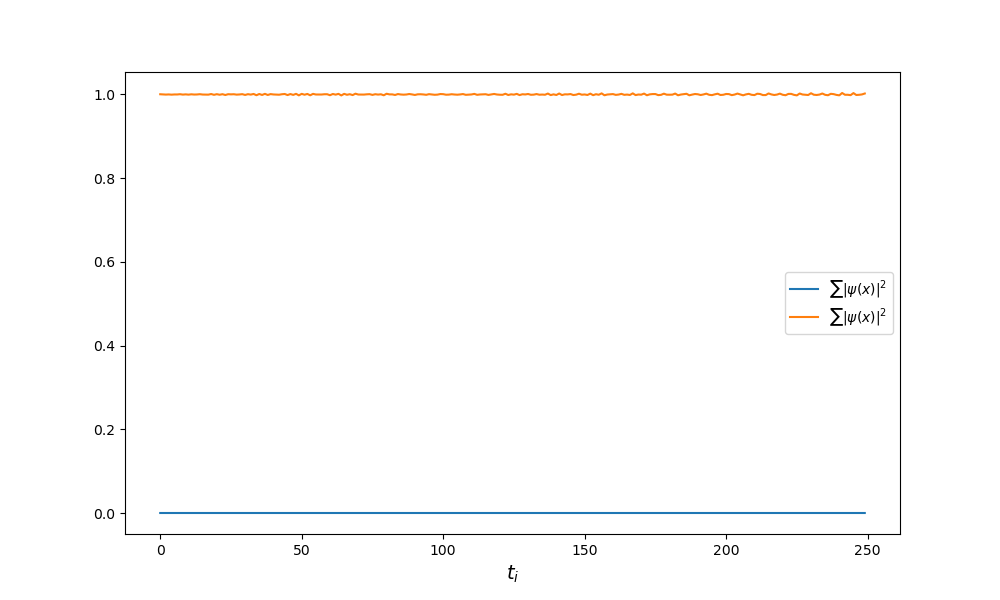

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(np.square(np.abs(t)), label = r'$ \sum |\psi(x)|^2$' )
plt.plot(np.square(np.abs(r)), label = r'$ \sum |\psi(x)|^2$' )
plt.xlabel(r'$t_i$', fontsize = 14)
#plt.ylim(q[0]-10, q[0]+10)

plt.legend()

<IPython.core.display.Javascript object>


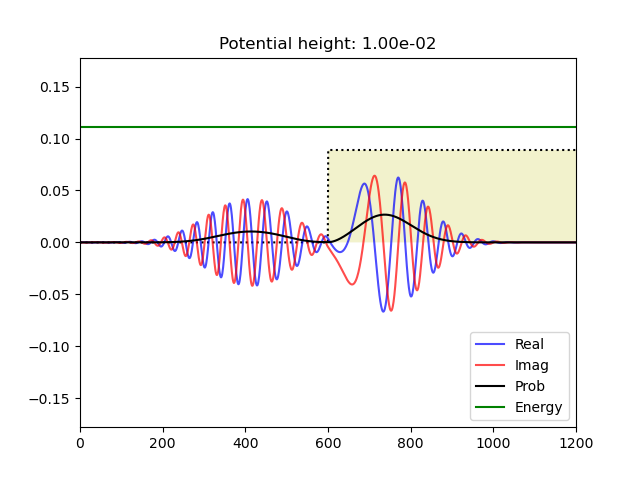

In [26]:
import numpy as np
import pylab
# Set pylab to interactive mode so plots update when run outside ipython
pylab.ion()
#=============================================================================
# Utility functions
#  Defines a quick Gaussian pulse function to act as an envelope to the wave
#  function.
def Gaussian(x,t,sigma):
    """  A Gaussian curve.
        x = Variable
        t = time shift
        sigma = standard deviation      """
    return np.exp(-(x-t)**2/(2*sigma**2))
def free(npts):
    "Free particle."
    return np.zeros(npts)
def step(npts,v0):
    "Potential step"
    v = free(npts)
    v[npts//2:] = v0
    return v
def barrier(npts,v0,thickness):
    "Barrier potential"
    v = free(npts)
    v[npts/2:npts/2+thickness] = v0
    return v
def fillax(x,y,*args,**kw):
    """Fill the space between an array of y values and the x axis.
    All args/kwargs are passed to the pylab.fill function.
    Returns the value of the pylab.fill() call.
    """
    xx = np.concatenate((x,np.array([x[-1],x[0]],x.dtype)))
    yy = np.concatenate((y,np.zeros(2,y.dtype)))
    return pylab.fill(xx, yy, *args,**kw)

#=============================================================================
#
#  Simulation Constants.  Be sure to include decimal points on appropriate
#  variables so they become floats instead of integers.
#
N    = 1200     #  Number of spatial points.
T    = 5*N      #  Number of time steps.  5*N is a nice value for terminating
                #  before anything reaches the boundaries.
Tp   = 50       #  Number of time steps to increment before updating the plot.
dx   = 1.0e0    #  Spatial resolution
m    = 1.0e0    #  Particle mass
hbar = 1.0e0    #  Plank's constant
X    = dx*np.linspace(0,N,N)        #  Spatial axis.
# Potential parameters.  By playing with the type of potential and the height
# and thickness (for barriers), you'll see the various transmission/reflection
# regimes of quantum mechanical tunneling.
V0   = 1.0e-2   #  Potential amplitude (used for steps and barriers)
THCK = 15       # "Thickness" of the potential barrier (if appropriate
                # V-function is chosen)
# Uncomment the potential type you want to use here:
# Zero potential, packet propagates freely.
#POTENTIAL = 'free'
# Potential step.  The height (V0) of the potential chosen above will determine
# the amount of reflection/transmission you'll observe
POTENTIAL = 'step'
# Potential barrier.  Note that BOTH the potential height (V0) and thickness
# of the barrier (THCK) affect the amount of tunneling vs reflection you'll
# observe.
#POTENTIAL = 'barrier'
#  Initial wave function constants
sigma = 40.0 # Standard deviation on the Gaussian envelope (remember Heisenberg
             #  uncertainty).
x0 = round(N/2) - 5*sigma # Time shift
k0 = np.pi/20 # Wavenumber (note that energy is a function of k)
# Energy for a localized gaussian wavepacket interacting with a localized
# potential (so the interaction term can be neglected by computing the energy
# integral over a region where V=0)
E = (hbar**2/2.0/m)*(k0**2+0.5/sigma**2)
#=============================================================================
# Code begins
#
# You shouldn't need to change anything below unless you want to actually play
# with the numerical algorithm or modify the plotting.
#
#  Fill in the appropriate potential function (is there a Python equivalent to
#  the SWITCH statement?).
if POTENTIAL=='free':
    V = free(N)
elif POTENTIAL=='step':
    V = step(N,V0)
elif POTENTIAL=='barrier':
    V = barrier(N,V0,THCK)
else:
    raise ValueError("Unrecognized potential type: %s" % POTENTIAL)
#  More simulation parameters.  The maximum stable time step is a function of
#  the potential, V.
Vmax = V.max()            #  Maximum potential of the domain.
dt   = hbar/(2*hbar**2/(m*dx**2)+Vmax)         #  Critical time step.
c1   = hbar*dt/(m*dx**2)                       #  Constant coefficient 1.
c2   = 2*dt/hbar                               #  Constant coefficient 2.
c2V  = c2*V  # pre-compute outside of update loop
# Print summary info
 
#  Wave functions.  Three states represent past, present, and future.
psi_r = np.zeros((3,N)) #  Real
psi_i = np.zeros((3,N)) #  Imaginary
psi_p = np.zeros(N,)   # Observable probability (magnitude-squared
                          #  of the complex wave function).
#  Temporal indexing constants, used for accessing rows of the wavefunctions.
PA = 0                 #  Past
PR = 1                 #  Present
FU = 2                 #  Future
#  Initialize wave function.  A present-only state will "split" with half the
#  wave function propagating to the left and the other half to the right.
#  Including a "past" state will cause it to propagate one way.
xn = range(1,N//2)
x = X[xn]/dx    #  Normalized position coordinate
gg = Gaussian(x,x0,sigma)
cx = np.cos(k0*x)
sx = np.sin(k0*x)
psi_r[PR,xn] = cx*gg
psi_i[PR,xn] = sx*gg
psi_r[PA,xn] = cx*gg
psi_i[PA,xn] = sx*gg
# Initial normalization of wavefunctions
#   Compute the observable probability.
psi_p = psi_r[PR]**2 + psi_i[PR]**2
#  Normalize the wave functions so that the total probability in the simulation
#  is equal to 1.
P   = dx * psi_p.sum()                      #  Total probability.
nrm = np.sqrt(P)
psi_r /= nrm
psi_i /= nrm
psi_p /= P
#  Initialize the figure and axes.
pylab.figure()
xmin = X.min()
xmax = X.max()
ymax = 1.5*(psi_r[PR]).max()
pylab.axis([xmin,xmax,-ymax,ymax])
#  Initialize the plots with their own line objects.  The figures plot MUCH
#  faster if you simply update the lines as opposed to redrawing the entire
#  figure.  For reference, include the potential function as well.
lineR, = pylab.plot(X,psi_r[PR],'b',alpha=0.7,label='Real')
lineI, = pylab.plot(X,psi_i[PR],'r',alpha=0.7,label='Imag')
lineP, = pylab.plot(X,6*psi_p,'k',label='Prob')
pylab.title('Potential height: %.2e' % V0)
# For non-zero potentials, plot them and shade the classically forbidden region
# in light red, as well as drawing a green line at the wavepacket's total
# energy, in the same units the potential is being plotted.
if Vmax !=0 :
    # Scaling factor for energies, so they fit in the same plot as the
    # wavefunctions
    Efac = ymax/2.0/Vmax
    V_plot = V*Efac
    pylab.plot(X,V_plot,':k',zorder=0)   #  Potential line.
    fillax(X,V_plot, facecolor='y', alpha=0.2,zorder=0)
    # Plot the wavefunction energy, in the same scale as the potential
    pylab.axhline(E*Efac,color='g',label='Energy',zorder=1)
pylab.legend(loc='lower right')
pylab.draw()
# I think there's a problem with pylab, because it resets the xlim after
# plotting the E line.  Fix it back manually.
pylab.xlim(xmin,xmax)
#  Direct index assignment is MUCH faster than using a spatial FOR loop, so
#  these constants are used in the update equations.  Remember that Python uses
#  zero-based indexing.
IDX1 = range(1,N-1)                            #  psi [ k ]
IDX2 = range(2,N)                              #  psi [ k + 1 ]
IDX3 = range(0,N-2)                            #  psi [ k - 1 ]
for t in range(T+1):
    # Precompute a couple of indexing constants, this speeds up the computation
    psi_rPR = psi_r[PR]
    psi_iPR = psi_i[PR]
    #  Apply the update equations.
    psi_i[FU,IDX1] = psi_i[PA,IDX1] +                       c1*(psi_rPR[IDX2] - 2*psi_rPR[IDX1] +
                          psi_rPR[IDX3])
    psi_i[FU] -= c2V*psi_r[PR]

    psi_r[FU,IDX1] = psi_r[PA,IDX1] -                       c1*(psi_iPR[IDX2] - 2*psi_iPR[IDX1] +
                          psi_iPR[IDX3])
    psi_r[FU] += c2V*psi_i[PR]
    #  Increment the time steps.  PR -> PA and FU -> PR
    psi_r[PA] = psi_rPR
    psi_r[PR] = psi_r[FU]
    psi_i[PA] = psi_iPR
    psi_i[PR] = psi_i[FU]
    #  Only plot after a few iterations to make the simulation run faster.
    if t % Tp == 0:
        #  Compute observable probability for the plot.
        psi_p = psi_r[PR]**2 + psi_i[PR]**2
        #  Update the plots.
        lineR.set_ydata(psi_r[PR])
        lineI.set_ydata(psi_i[PR])
        # Note: we plot the probability density amplified by a factor so it's a
        # bit easier to see.
        lineP.set_ydata(6*psi_p)

        pylab.draw()
# So the windows don't auto-close at the end if run outside ipython
pylab.ioff()
pylab.show()

In [46]:
import numpy as np
from scipy.linalg import eig_banded
import multiprocessing
import matplotlib.pyplot as plt
import contextlib
import collections
from functools import reduce


def lorentz(x, x_0=0, s=1):
    """
    https://en.wikipedia.org/wiki/Spectral_line_shape
    """
    y = 2 * (x - x_0) / s
    return 1 / (y**2 + 1)


def gauss(x, x_0=0, s=1):
    """
    https://en.wikipedia.org/wiki/Spectral_line_shape
    """
    y = (x - x_0) / s
    return np.exp(-y**2 / 2) / s


def V(x, *args, **kwargs):
    """
    potential to use
    """
    l = args[0]
    #return lorentz(x, 0, 5 * l) - 1.1 * lorentz(x, 0, 2.5 * l)
    return (0.2 * (gauss(x, -1.5, 3 * l) + gauss(x, 1.5, 3 * l))
            - 0.5 * gauss(x, 0, 6.1 * l) ** 2)
    # For testing:
    # return np.zeros_like(x)


def get_scattering_state(E, x, pot, hbareff):
    """
    Use the shooting method to get |psi>
    Note: As it is a scattering state, every psi is a solution
    See Also
    --------
    [[example_scattering_1d.org]]: file with details
    """
    # For x at -L_max we assume
    # psi = exp(i k x) = exp(-i k L_max) and
    # d psi / dx = i k * psi
    N = len(x)
    dx = x.ptp() / (N - 1)
    z = hbareff ** 2 / 2 / dx ** 2

    # estimate the wavelength on the left and right (in indices)
    n_wavelengths = 4
    # this is k * dx
    k_left_0_dx = np.sqrt((E - pot[0]) / z)
    k_right_0_dx = np.sqrt((E - pot[-1]) / z)

    # Note: We need the min condition in case E is too small and the
    # wavelength diverges
    idx_wavelength_l = min(N // 20, int(np.ceil(
        2 * np.pi * n_wavelengths / k_left_0_dx)))
    idx_wavelength_r = min(N // 20, int(np.ceil(
        2 * np.pi * n_wavelengths / k_right_0_dx)))

    # we assume the potential is constant over these ranges
    k_left = np.sqrt((E - pot[:idx_wavelength_l]) / z) / dx
    k_right = np.sqrt((E - pot[-idx_wavelength_r:]) / z) / dx

    offset = np.exp(-1j * k_right[-1] * x[-1])

    # We only check on a fraction of the array -- it suffices.
    # We use the arrays for plotting outside
    np.testing.assert_array_less(
        k_left[:len(k_left) // 10].std(), 5e-2,
        err_msg="potential not constant at the left: k_left={0}".format(
            list(k_left[:len(k_left)])))
    np.testing.assert_array_less(
        k_right[:len(k_right) // 10].std(), 5e-2,
        err_msg="potential not constant at the right")

    def iterate(psi_ip1, psi_i, V_ip1):
        """
        get psi_{i + 2} = psi_ip2 from psi_ip1 and psi_1
        """
        return (2 - (E - V_ip1) / z) * psi_ip1 - psi_i

    def get_psi(r):
        """
        calculate the transmission amplitude from the reflection
        """
        # now we can construct the rest of the function
        psi = np.empty(N, dtype=np.complex)
        psi[0] = offset * (
            np.exp(1j * k_left[0] * x[0]) +
            r * np.exp(-1j * k_left[0] * x[0]))
        psi[1] = offset * (
            np.exp(1j * k_left[0] * (x[0] + dx)) +
            r * np.exp(-1j * k_left[0] * (x[0] + dx)))

        for i in range(N - 2):
            psi[i + 2] = iterate(psi[i + 1], psi[i], pot[i + 1])

        return psi

    transfer_M = reduce(
        lambda M, V_ip1: np.dot(
            np.array([[0, 1], [
                iterate(0, 1, 0),
                iterate(1, 0, V_ip1)]]), M),
        pot[1:-1], np.eye(2))

    # create the scattering matrix
    y_1 = np.exp(-1j * k_left_0_dx)
    y_2 = np.exp(-1j * k_right_0_dx)
    Y_1 = np.exp(1j * k_left_0_dx * x[0] / dx)
    Y_2 = np.exp(1j * k_right_0_dx * x[-1] / dx)

    g_1 = Y_2 * np.array([y_2, 1])
    g_2 = 1 / Y_2 * np.array([1 / y_2, 1])
    M_d_1 = np.dot(transfer_M, Y_1 * np.array([1, 1 / y_1]))
    M_d_2 = np.dot(transfer_M, 1 / Y_1 * np.array([1, y_1]))

    S = np.dot(
        np.linalg.inv(np.array([
            [-M_d_2[0], g_1[0]],
            [-M_d_2[1], g_1[1]]])),
        np.array([
            [M_d_1[0], g_2[0]],
            [M_d_1[1], g_2[1]]]))

    # we can re-cast the problem in terms of the the transfer matrix:
    c = np.dot(transfer_M, np.array([1, np.exp(1j * k_left_0_dx)])) * (
        np.exp(1j * k_left[0] * x[0])) * offset
    d = np.exp(-1j * k_left[0] * x[0]) * offset * np.dot(
        transfer_M, np.array([1, np.exp(-1j * k_left_0_dx)]))
    g = np.array([np.exp(-1j * k_right_0_dx), 1])
    # we now have to solve
    # c + r * d - t * g = 0
    # and |r|^2 + |t|^2 = 1

    A = np.linalg.inv(np.array([d, g]).T)
    amplitudes = np.dot(A, c)
    r, t = amplitudes

    # The scattering state corresponds to
    # a1 = 1, b1 = r, a2 = 0, b2 = t so
    # r = (S * [1, 0]^T)[0] = S[0, 0]
    psi = get_psi(S[0, 0])

    # Norm such that the integral over the visible region is 1
    # Note: Commented out as this has the downside that we cannot see
    # the incident wave if we hit a resonance --> the resonance is just
    # to efficiently coupled and gets blown up.
    # c_norm = dx * np.sum(np.abs(psi)**2)
    # psi = psi / np.sqrt(c_norm)

    # we norm such that the part of the plane-wave component has a
    # maximum of one
    # Note: The asymptotic scattering function is given by
    # psi = offset * ( (1 + r) cos(k x) + i (1 - r) sin(k x))
    # (Note that r is complex itself)
    # psi = offset * (e^ikx + |r| e^i(delta_r - kx))
    # but we can get a good bound by:
    psi /= np.abs(1 + np.abs(r))

    return S, psi, t, r, k_left, k_right


class QuantumSystem(object):
    """
    Define the necessary parameters
    """
    def __init__(self, hbareff=0.1, N=200, L_max=5,
                 potential_args=(0.2, )):
        """
        Set up the scattering state
        """
        self.hbareff = hbareff
        self.N = N
        self.potential_args = potential_args

        # first plot the potential
        self.L_max = L_max
        self.x, self.dx = np.linspace(
            -L_max, L_max, N, retstep=True)
        self.pot = self.V(self.x, *potential_args)

    def V(self, *args):
        """
        return the potential in use
        """
        return V(*args)

    def plot_psi(self, psi, E):
        """
        scale the plot of the wavefunction
        The prefactor is just for visibility
        """
        return E + 0.1 * np.abs(psi) ** 2


class ClosedSystem(QuantumSystem):
    """
    Diagonalize the problem using Dirichlet conditions
    """
    def __init__(self, *args, **kwargs):
        super(ClosedSystem, self).__init__(*args, **kwargs)

        # adjust self.x to account for the maxima of the potential
        dpot = np.diff(self.pot)
        idx_left = np.nonzero(dpot < 0)[0][0] + 1
        idx_right = np.nonzero(dpot > 0)[0][-1]
        self.x, self.dx = np.linspace(
            self.x[idx_left], self.x[idx_right], self.N, retstep=True)
        self.pot = self.V(self.x, *self.potential_args)

    def create_H_banded(self):
        """
        create banded matrix for diagonalization
        """
        H_banded = np.zeros((2, self.N), dtype=float)
        z = self.hbareff**2 / (2 * self.dx ** 2)

        # main diagonal = 1st band (in lower storage)
        H_banded[0, :] = 2 * z + self.pot
        H_banded[1, :-1] = - z

        return H_banded

    def get_evals_evecs(self):
        """
        get bound states
        """
        H = self.create_H_banded()
        evals, evecs = eig_banded(
            H, lower=True, select="v",
            select_range=(self.pot.min(),
                          self.pot.max()))
        # fix the eigenvector norm to the position space integral
        evecs /= np.sqrt(self.dx)
        return evals, evecs

    def plot_evecs_to(self, ax):
        """
        plot all found eigenvectors to ax
        """
        evals, evecs = self.get_evals_evecs()

        for eigval, evec in zip(evals, evecs.T):
            ax.plot(
                self.x, self.plot_psi(evec, eigval),
                color="g", alpha=0.4)


class ScatteringState(QuantumSystem):
    """
    combine the current scattering info
    """
    def get_state(self, E):
        """
        calculate the scattering state
        This is the state incident from the left
        with no component entering from the right
        """
        S, psi, t, r, k_l, k_r = get_scattering_state(
            E, self.x, self.pot,
            self.hbareff)

        return S, psi, t, r, k_l, k_r

    def get_S(self, E):
        """
        calculate S matrix
        """
        S, psi, t, r, k_l, k_r = get_scattering_state(
            E, self.x, self.pot,
            self.hbareff)
        return S

    def plot_state_at_E(self, ax, ax_phase, ax_trans, E):
        """
        plot psi to ax, E to ax_phase
        """
        S, psi, t, r, k_l, k_r = self.get_state(E)
        delta = np.angle(t)

        try:
            psi_plot_baseline = self.psi_plot_baseline
        except AttributeError:
            self.psi_plot_baseline = ax.plot(
                self.x, self.plot_psi(np.zeros_like(self.x), E),
                color="k", lw=0.5, alpha=0.5)[0]
        else:
            psi_plot_baseline.set_ydata(
                self.plot_psi(np.zeros_like(self.x), E))

        try:
            psi_plot = self.psi_plot
        except AttributeError:
            self.psi_plot = ax.plot(
                self.x, self.plot_psi(psi, E), color="r")[0]
        else:
            psi_plot.set_ydata(self.plot_psi(psi, E))

        # also plot a comparison for the phase shift
        where = slice(len(k_l))
        psi_in = np.exp(1j * k_l * self.x[where])
        try:
            psi_in_plot = self.psi_in_plot
        except AttributeError:
            self.psi_in_plot = ax.plot(
                self.x[where], self.plot_psi(psi_in[where], E),
                color="b", alpha=0.3)[0]
        else:
            psi_in_plot.set_data(
                self.x[where], self.plot_psi(psi_in[where], E))

        where = slice(-len(k_r), None)
        psi_out = np.exp(1j * k_r * self.x[where] + 1j * delta)
        try:
            psi_out_plot = self.psi_out_plot
        except AttributeError:
            self.psi_out_plot = ax.plot(
                self.x[where], self.plot_psi(psi_out[where], E),
                color="g", alpha=0.3)[0]
        else:
            psi_out_plot.set_data(
                self.x[where],
                self.plot_psi(psi_out[where], E))

        # add a straight line at the phase plot
        try:
            E_in_phase = self.E_in_phase
        except AttributeError:
            self.E_in_phase = ax_phase.axvline(
                E, color="k", lw=0.5, alpha=0.5)
        else:
            E_in_phase.set_xdata([E, E])

        # add a straight line at the phase plot
        try:
            E_in_trans = self.E_in_trans
        except AttributeError:
            self.E_in_trans = ax_trans.axvline(
                E, color="k", lw=0.5, alpha=0.5)
        else:
            E_in_trans.set_xdata([E, E])


class Heff(QuantumSystem):
    """
    Holds the closed sys and the scattering state
    """
    def __init__(self, *args, **kwargs):
        self.scat = ScatteringState(*args, **kwargs)
        self.Hsys = ClosedSystem(*args, **kwargs)
        super(Heff, self).__init__(*args, **kwargs)

    def __getattr__(self, name):
        """
        propagate to the classes contained
        """
        scattering_state = self.__dict__.get(
            "scat", NotImplemented)
        hamilton_system = self.__dict__.get(
            "Hsys", NotImplemented)
        value = getattr(
            scattering_state, name,
            getattr(hamilton_system, name,
                    NotImplemented))
        if value is NotImplemented:
            raise AttributeError("No {0} on {1}".format(name, self))
        else:
            return value


@contextlib.contextmanager
def pool(*args, **kwargs):
    yield multiprocessing.Pool(*args, **kwargs)


def get_S_t_r(args):
    """
    return all things necessary for plotting
    """
    scatstate, E = args
    S, _, t, r = scatstate.get_state(E)[:4]
    return np.concatenate([S.flatten(), np.array([t, r])])


def main(afterwards=plt.show, savefig=False):
    """
    Make an example plot
    """
    scatstate = Heff(
        hbareff=0.2, N=3500, L_max=5,
        potential_args=(0.2, ))

    # Note: The lower lying states are too close to E=0
    # for the choosem L_max!
    E = 0.122698680068     # 3rd  (2 zeros)
    E = 0.2514             # 4th  (3 zeros)
    # --- pot maximum: 0.2692 ---
    E = 0.3815             # 5th  (4 zeros)

    N_E = 5000
    E_delta = np.linspace(
        scatstate.pot[0] + 0.001, 2, N_E)

    description = "_".join([
        "E_min={0:1.7f}".format(E_delta.min()),
        "E_max={0}".format(E_delta.max()),
        "E_N={0}".format(N_E),
        "hbar_{0}".format(scatstate.hbareff),
        "N_{0}".format(scatstate.N),
        "L_max={0}".format(scatstate.L_max),
        "potential={0}".format(scatstate.potential_args[0])])

    cache = "example_scattering_1d_cached_values{desc}.dat".format(
        desc=description)
    try:
        tr_amp = np.memmap(cache, mode="r", dtype=complex)
    except (IOError, ValueError):
        print("Calculating ... ({0})".format(cache))
        with pool() as p:
            tr_amp = np.array(p.map(
                get_S_t_r, [(scatstate, E_) for E_ in E_delta]))

        tr_amp.tofile(cache)
        print("Wrote {0}".format(cache))
    else:
        tr_amp = tr_amp.reshape((N_E, -1))
        print("Read {0}".format(cache))

    S = tr_amp[:, :4].reshape(-1, 2, 2)

    fig = plt.figure(1)
    ax = fig.add_subplot(121)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$E$ / $|\psi|^{2}$")
    ax.plot(scatstate.x, scatstate.pot,
            "k-")
    ax.plot(scatstate.x, np.zeros_like(scatstate.x),
            color="k", lw=0.5, alpha=0.5)
    scatstate.plot_evecs_to(ax)
    ax.set_ylim(min(-.1, 1.1 * scatstate.pot.min()),
                max(E + 1, 1.1 * scatstate.pot.max()))

    ax_phase = fig.add_subplot(222)
    ax_phase.set_xlabel(r"$E$")
    ax_phase.set_ylabel(r"$\delta_t$ / $\delta_r$")
    phases = np.angle(S[:, 1, 0])
    where = E_delta > 0.02
    phases[where] = np.unwrap(phases[where])
    ax_phase.plot(E_delta, phases,
                  "b-", lw=3, marker=".", alpha=0.5)
    phases = np.angle(S[:, 0, 0])
    phases[where] = np.unwrap(phases[where])
    ax_phase.plot(E_delta, phases,
                  "r-", lw=3, marker=".", alpha=0.5)

    ax_trans = fig.add_subplot(224, sharex=ax_phase)
    ax_trans.set_xlabel(r"$E$")
    ax_trans.set_ylabel(r"$|t|^2$, $|r|^2$")
    ax_trans.plot(E_delta, np.abs(S[:, 1, 0]) ** 2, "b-", label=r"$T$")
    ax_trans.plot(E_delta, np.abs(S[:, 0, 0]) ** 2, "r-", label=r"$R$")

    # mark the potential maximum
    ax_phase.axvline(scatstate.pot.max(), color="k", ls="-")
    ax_trans.axvline(scatstate.pot.max(), color="k", ls="-")

    # get a wave function
    scatstate.plot_state_at_E(ax, ax_phase, ax_trans, E)
    ax_trans.legend(loc="center right")
    ax_trans.set_xlim(0.1, 0.55)
    ax_trans.set_ylim(-0.01, 1.01)

    def set_energy_from_mouse(event):
        if plt.get_current_fig_manager().toolbar.mode != '':
            return
        if event.button != 1:
            return
        if event.inaxes is ax:
            E = event.ydata
        elif event.inaxes in [ax_phase, ax_trans]:
            E = event.xdata
        else:
            return
        set_energy(E)

    def set_energy_from_key(event):
        if event.inaxes is ax:
            step = np.ptp(event.inaxes.get_ylim()) / 50
            if event.key in ["up"]:
                E = set_energy.current_E + step
            elif event.key in ["down"]:
                E = set_energy.current_E - step
            else:
                return
        elif event.inaxes in [ax_phase, ax_trans]:
            step = np.ptp(event.inaxes.get_xlim()) / 50
            if event.key == ";":
                E = set_energy.current_E + step
            elif event.key == "j":
                E = set_energy.current_E - step
            else:
                return
        else:
            return
        set_energy(E)

    def set_energy(E):
        set_energy.current_E = E

        print("Setting E={0}".format(E))
        scatstate.plot_state_at_E(ax, ax_phase, ax_trans, E)
        plt.draw()

    set_energy.current_E = E

    fig.subplots_adjust(wspace=0.30, right=0.95)
    plt.connect('button_press_event', set_energy_from_mouse)
    plt.connect('key_press_event', set_energy_from_key)

    if savefig:
        filename = "./figures/example_scattering_1d.svg"
        fig.savefig(filename, transparent=True)
        print("Wrote {0}".format(filename))

    print("""
1D Scattering System
--------------------
You can control the incident energy by mouse on the left
and on the lower right panel. The current energy is indicated
by a grey line.
Furthermore you can use the following keys:
| axis        | key  | description                                |
|-------------+------+--------------------------------------------|
| left        | up   | increase E by fraction of displayed y-axis |
|             | down | decrease E by fraction of displayed y-axis |
| lower right | ;    | increase E by fractino of displayed x-axis |
|             | j    | decrease E by fractino of displayed x-axis |
(Reason for these keys are the default keys of matplotlib)
""")

    if isinstance(afterwards, collections.Callable):
        afterwards()


if __name__ == "__main__":

    main(savefig=False)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy.fftpack import fft, fftfreq, fftshift
from TMM_functions import eigen_modes as em
from TMM_functions import scatter_matrices as sm
from RCWA_functions import redheffer_star as rs
from RCWA_functions import rcwa_initial_conditions as ic
from RCWA_functions import homogeneous_layer as hl
from scipy import linalg as LA


# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
np.set_printoptions(precision = 4)
def grating_fourier_harmonics(order, fill_factor, n_ridge, n_groove):
    """ function comes from analytic solution of a step function in a finite unit cell"""
    #n_ridge = index of refraction of ridge (should be dielectric)
    #n_ridge = index of refraction of groove (air)
    #n_ridge has fill_factor
    #n_groove has (1-fill_factor)
    # there is no lattice constant here, so it implicitly assumes that the lattice constant is 1...which is not good

    if(order == 0):
        return n_ridge**2*fill_factor + n_groove**2*(1-fill_factor);
    else:
        #should it be 1-fill_factor or fill_factor?, should be fill_factor
        return(n_ridge**2 - n_groove**2)*np.sin(np.pi*order*(fill_factor))/(np.pi*order);

def grating_fourier_array(num_ord, fill_factor, n_ridge, n_groove):
    """ what is a convolution in 1D """
    fourier_comps = list();
    for i in range(-num_ord, num_ord+1):
        fourier_comps.append(grating_fourier_harmonics(i, fill_factor, n_ridge, n_groove));
    return fourier_comps;

def fourier_reconstruction(x, period, num_ord, n_ridge, n_groove, fill_factor = 0.5):
    index = np.arange(-num_ord, num_ord+1);
    f = 0;
    for n in index:
        coef = grating_fourier_harmonics(n, fill_factor, n_ridge, n_groove);
        f+= coef*np.exp(cmath.sqrt(-1)*np.pi*n*x/period);
        #f+=coef*np.cos(np.pi*n*x/period)
    return f;

def fourier_reconstruction_general(x, period, num_ord, coefs):
    '''
    overloading odesn't work in python...fun fact, since it is dynamically typed (vs statically typed)
    :param x:
    :param period:
    :param num_ord:
    :param coefs:
    :return:
    '''
    index = np.arange(-num_ord, num_ord+1);
    f = 0; center = int(len(coefs)/2); #no offset
    for n in index:
        coef = coefs[center+n];
        f+= coef*np.exp(cmath.sqrt(-1)*2*np.pi*n*x/period);
    return f;

def grating_fft(eps_r):
    assert len(eps_r.shape) == 2
    assert eps_r.shape[1] == 1;
    #eps_r: discrete 1D grid of the epsilon profile of the structure
    fourier_comp = np.fft.fftshift(np.fft.fft(eps_r, axis = 0)/eps_r.shape[0]);
    #ortho norm in fft will do a 1/sqrt(n) scaling
    return np.squeeze(fourier_comp);

# plt.plot(x, np.real(fourier_reconstruction(x, period, 1000, 1,np.sqrt(12), fill_factor = 0.1)));
# plt.title('check that the analytic fourier series works')
# #'note that the lattice constant tells you the length of the ridge'
# plt.show()

L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;
fill_factor = 0.3; # 50% of the unit cell is the ridge material


num_ord = 10; #INCREASING NUMBER OF ORDERS SEEMS TO CAUSE THIS THING TO FAIL, to many orders induce evanescence...particularly
               # when there is a small fill factor
PQ = 2*num_ord+1;
indices = np.arange(-num_ord, num_ord+1)

n_ridge = 3.48; #3.48;              # ridge
n_groove = 1;                # groove (unit-less)
lattice_constant = 0.7;  # SI units
# we need to be careful about what lattice constant means
# in the gaylord paper, lattice constant exactly means (0, L) is one unit cell


d = 0.46;               # thickness, SI units

Nx = 2*256;
eps_r = n_groove**2*np.ones((2*Nx, 1)); #put in a lot of points in eps_r
border = int(2*Nx*fill_factor);
eps_r[0:border] = n_ridge**2;
fft_fourier_array = grating_fft(eps_r);
x = np.linspace(-lattice_constant,lattice_constant,1000);
period = lattice_constant;
fft_reconstruct = fourier_reconstruction_general(x, period, num_ord, fft_fourier_array);

fourier_array_analytic = grating_fourier_array(Nx, fill_factor, n_ridge, n_groove);
analytic_reconstruct = fourier_reconstruction(x, period, num_ord, n_ridge, n_groove, fill_factor)


plt.figure();
plt.plot(np.real(fft_fourier_array[Nx-20:Nx+20]), linewidth=2)
plt.plot(np.real(fourier_array_analytic[Nx-20:Nx+20]));
plt.legend(('fft', 'analytic'))
plt.show()

plt.figure();
plt.plot(x,fft_reconstruct)
plt.plot(x,analytic_reconstruct);
plt.legend(['fft', 'analytic'])
plt.show()
theta_inc = 0;
spectra = list();
spectra_T = list();

wavelength_scan = np.linspace(0.5,2.3,300)
## construct permittivity harmonic components E
#fill factor = 0 is complete dielectric, 1 is air


##construct convolution matrix
E_conv = np.zeros((2 * num_ord + 1, 2 * num_ord + 1));
E_conv = E_conv.astype('complex')
p0 = Nx;
p_index = np.arange(-num_ord, num_ord + 1);
fourier_array = fft_fourier_array; #_analytic;
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        E_conv[prow, pcol] = fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

I = np.identity(2*num_ord+1);
# E is now the convolution of fourier amplitudes
for lam0 in wavelength_scan:
    k0 = 2*np.pi/lam0; #free space wavelength in SI units
    print('wavelength: ' + str(lam0));
    ## =====================STRUCTURE======================##

    ## Region I
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary
    ## Region 2; transmission
    n2 = 1;

    #from the kx_components given the indices and wvln
    #2 * np.pi * np.arange(-N_p, N_p + 1) / (k0 * a_x)
    indices = np.arange(-num_ord, num_ord + 1)

    kx_array = (n1*np.sin(theta_inc) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi

    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag(kx_array); #singular since we have a n=0, m= 0 order and incidence is normal

    ## construct matrix of Gamma^2 ('constant' term in ODE):
    P = -I; #conditioning of this matrix is not bad, this is the mode matrix for Hz
    #sum of a symmetric matrix and a diagonal matrix should be symmetric;
    Q = E_conv - KX @ KX;
    PQ = P@Q;

    ## ================================================================================================##
    eigenvals, W = LA.eigh(PQ); #A should be symmetric or hermitian
    #we should be gauranteed that all eigenvals are REAL
    eigenvals = eigenvals.astype('complex');
    lambda_matrix = np.diag((np.sqrt((eigenvals))));

    ## THIS NEGATIVE SIGN IS CRUCIAL, but I'm not sure why
    V = -em.eigen_V(Q, W, lambda_matrix)
    kz_inc = n1;
    ## ================================================================================================##

    ## scattering matrix needed for 'gap medium'
    #if calculations shift with changing selection of gap media, this is BAD; it should not shift with choice of gap
    Wg,Vg, Kzg = hl.homogeneous_1D(KX, 1, m_r = 1)
    ## reflection medium
    Wr,Vr, Kzr = hl.homogeneous_1D(KX, 1, m_r = 1)
    ## transmission medium;
    Wt,Vt, Kzt = hl.homogeneous_1D(KX, 1, m_r = 1)

    ## S matrices for the reflection region
    #Ar, Br = sm.A_B_matrices(Wg, Wr, Vg, Vr);
    Ar, Br = sm.A_B_matrices_half_space(Wr, Wg, Vr, Vg);  # make sure this order is right

    S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region    ## calculating A and B matrices for scattering matrix
    Sg = Sr_dict;

    ## define S matrix for the GRATING REGION
    A, B = sm.A_B_matrices(W, Wg,  V, Vg);
    S, S_dict = sm.S_layer(A, B, d, k0, lambda_matrix)
    Sg_matrix, Sg = rs.RedhefferStar(Sg, S_dict)

    ## define S matrices for the Transmission region
    At, Bt = sm.A_B_matrices_half_space(Wt, Wg, Vt, Vg);  # make sure this order is right
    St, St_dict = sm.S_T(At, Bt); #scatter matrix for the reflection region
    Sg_matrix, Sg = rs.RedhefferStar(Sg, St_dict)

    #check scattering matrix is unitary
    #print(np.linalg.norm(np.linalg.inv(Sg_matrix)@Sg_matrix - np.matrix(np.eye(2*(2*num_ord+1)))))

    ## ======================== CALCULATE R AND T ===============================##
    K_inc_vector =  n1*np.matrix([np.sin(theta_inc), \
                                         0, np.cos(theta_inc)]);
    #K_inc isn't even used for anyting...

    #cinc is the incidence vector
    cinc = np.zeros((2*num_ord+1, )); #only need one set...
    cinc[num_ord] = 1;
    cinc = cinc.T;
    cinc = np.linalg.inv(Wr) @ cinc;
    ## COMPUTE FIELDS: similar idea but more complex for RCWA since you have individual modes each contributing
    reflected = Wr @ Sg['S11'] @ cinc;
    transmitted = Wt @ Sg['S21'] @ cinc;

    ## reflected is already ry or Ey
    rsq = np.square(np.abs(reflected));
    tsq = np.square(np.abs(transmitted));

    ## compute final reflectivity
    Rdiff = np.real(Kzr)@rsq/np.real(kz_inc); #real because we only want propagating components
    Tdiff = np.real(Kzt)@tsq/np.real(kz_inc)
    R = np.sum(Rdiff);
    T = np.sum(Tdiff);

    print(R);
    spectra.append(R); #spectra_T.append(T);
    spectra_T.append(T)

plt.figure();
plt.plot(wavelength_scan, spectra);
plt.plot(wavelength_scan, spectra_T)
plt.plot(wavelength_scan, np.array(spectra)+np.array(spectra_T))
plt.legend(['reflection', 'transmission'])
plt.show()

ModuleNotFoundError: No module named 'TMM_functions'

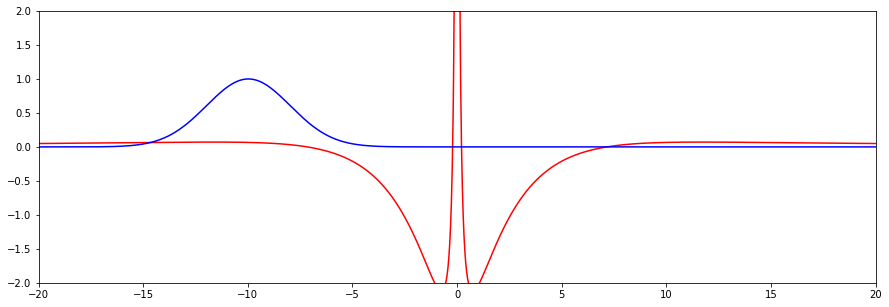

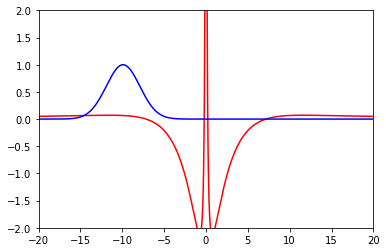

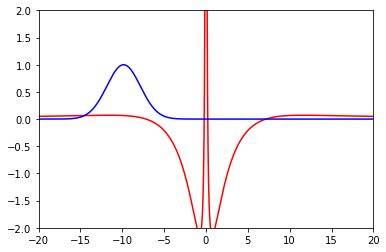

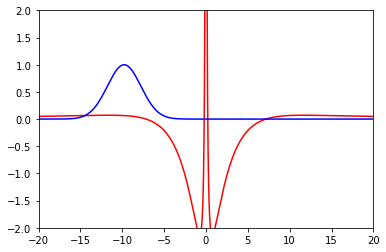

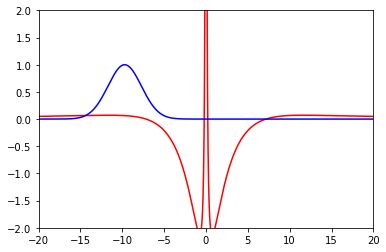

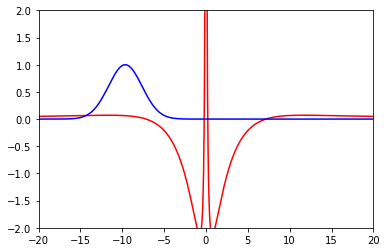

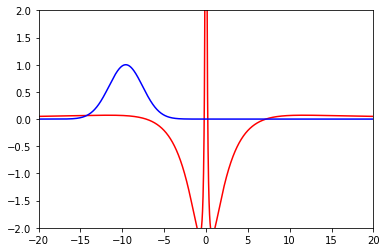

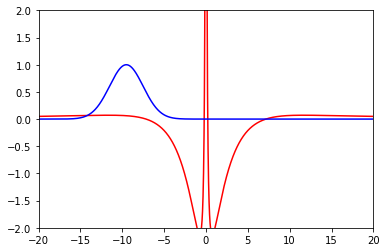

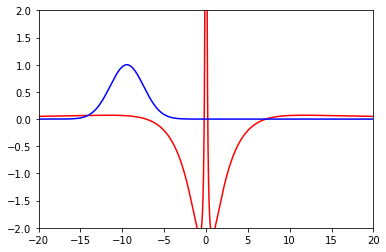

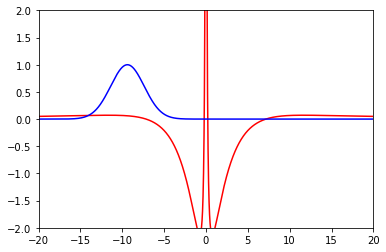

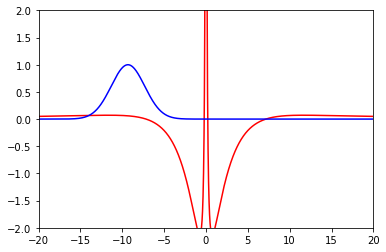

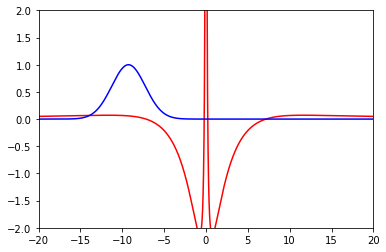

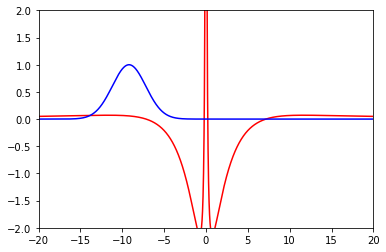

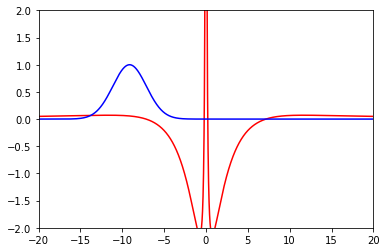

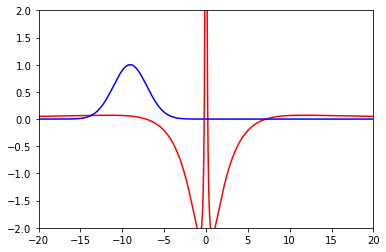

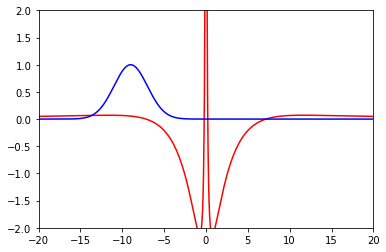

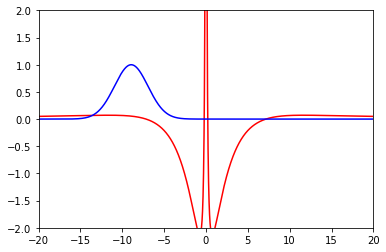

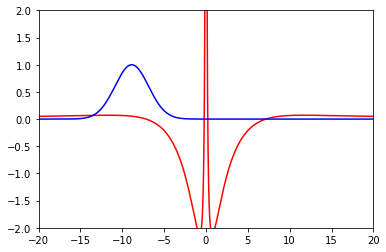

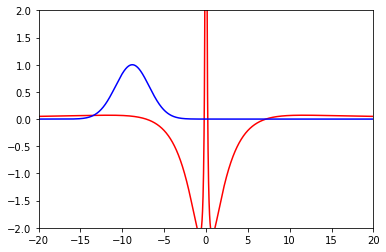

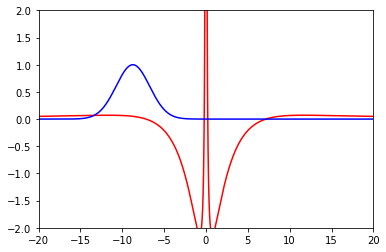

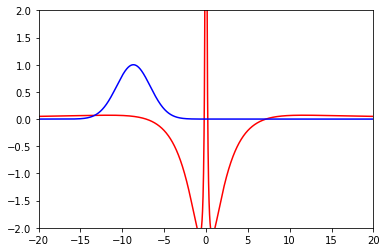

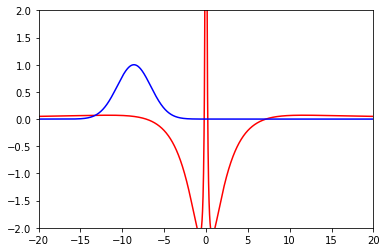

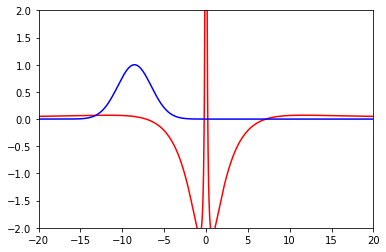

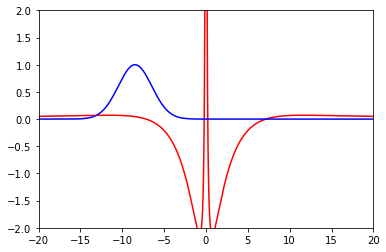

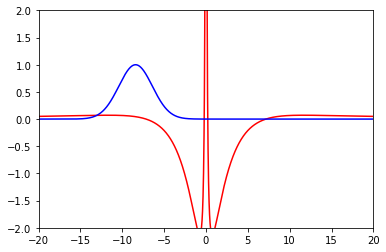

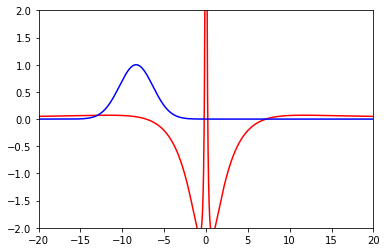

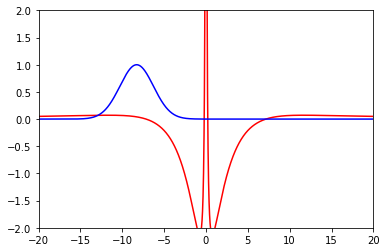

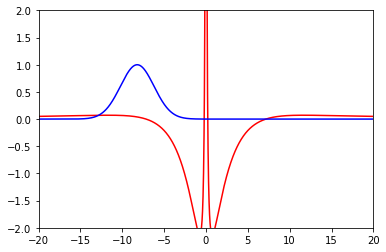

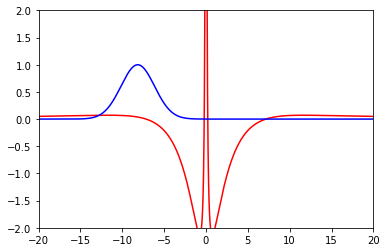

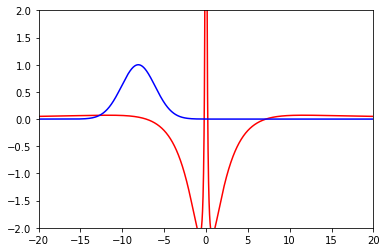

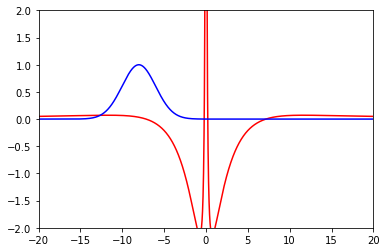

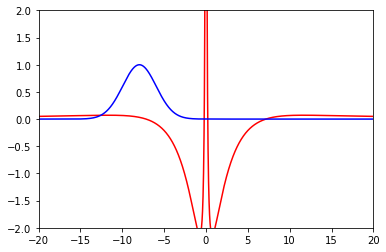

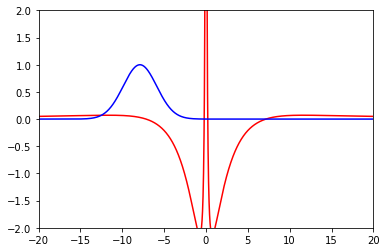

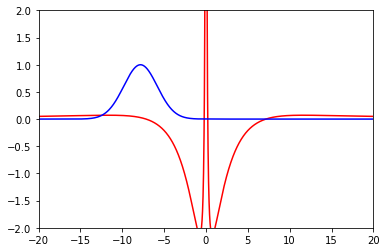

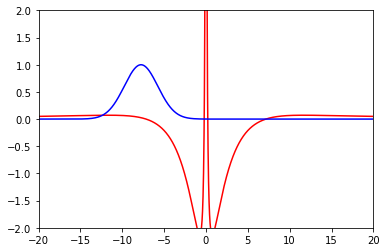

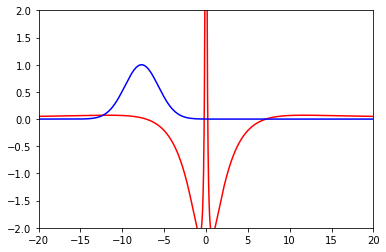

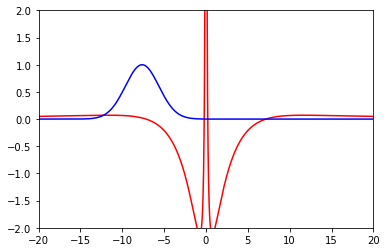

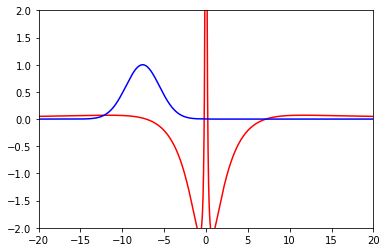

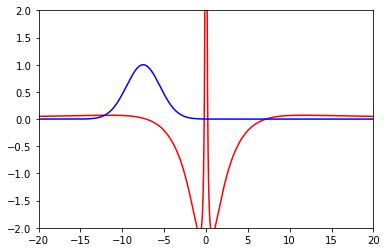

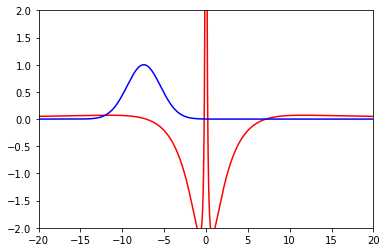

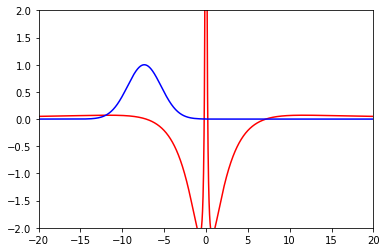

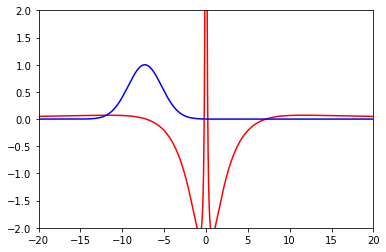

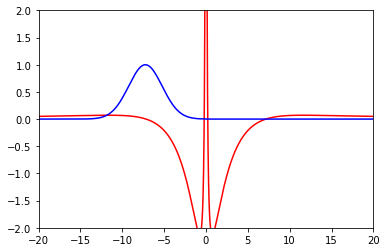

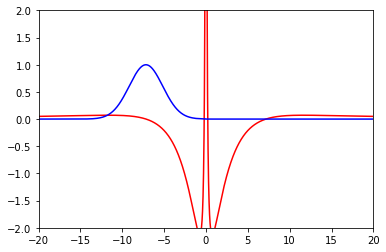

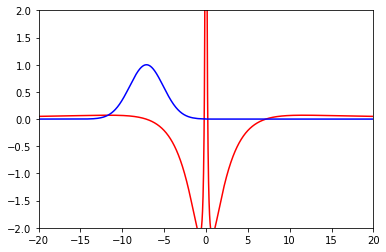

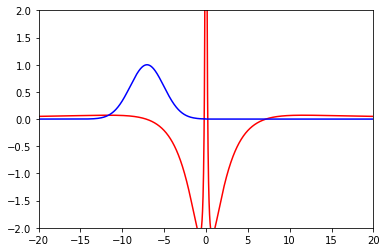

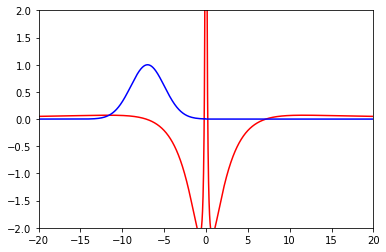

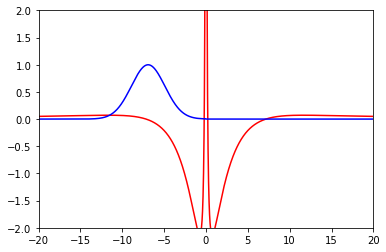

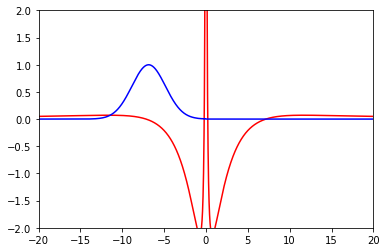

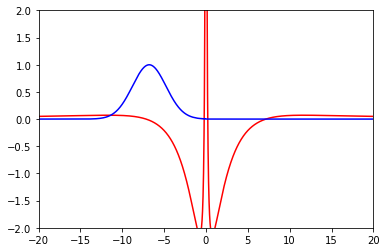

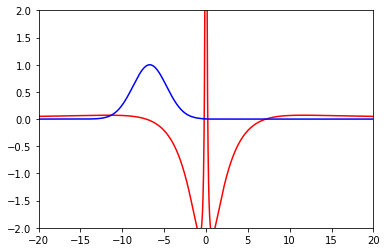

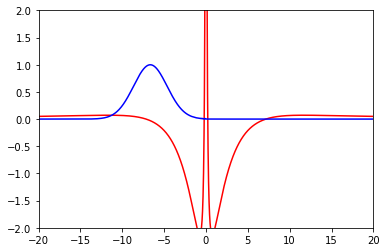

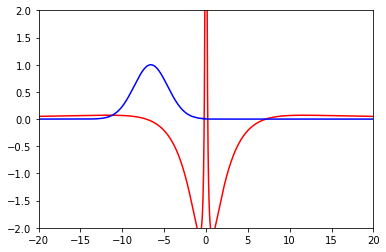

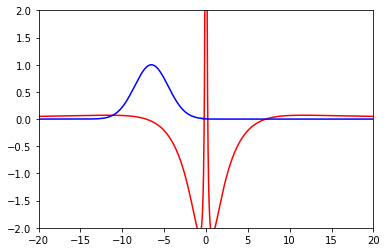

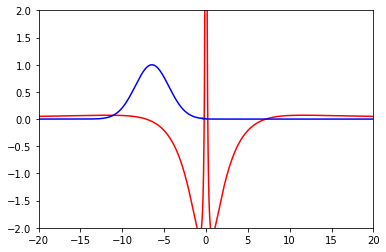

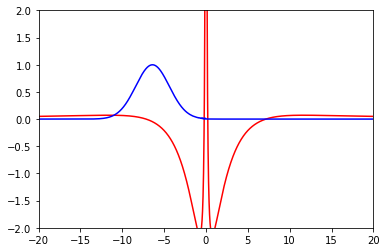

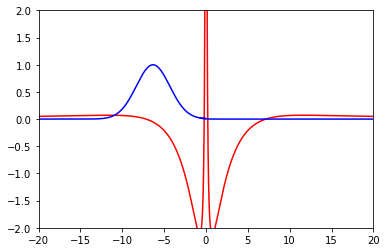

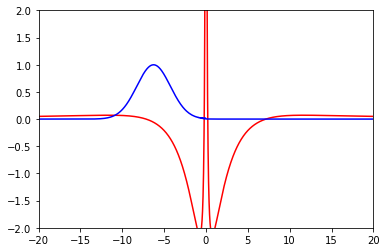

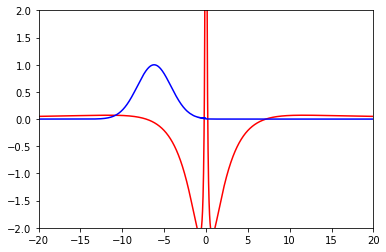

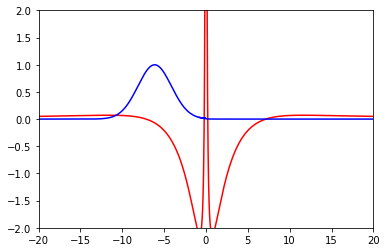

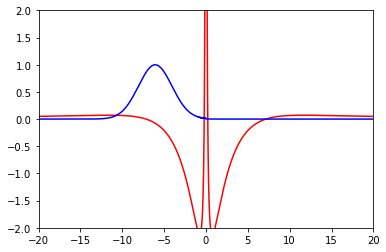

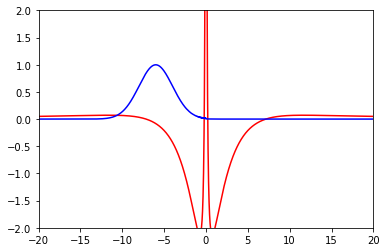

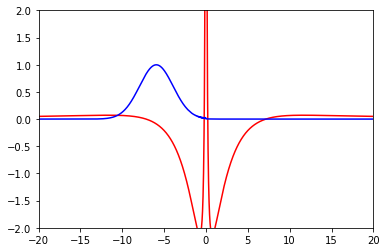

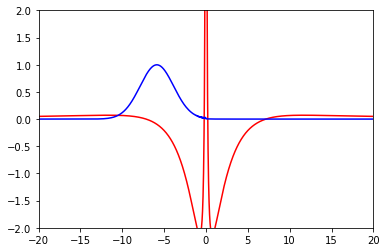

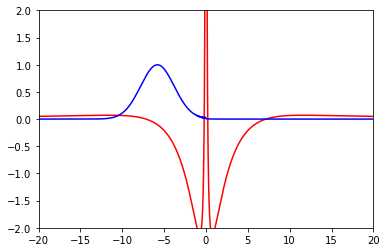

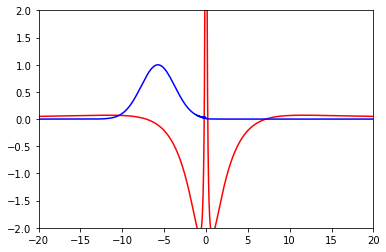

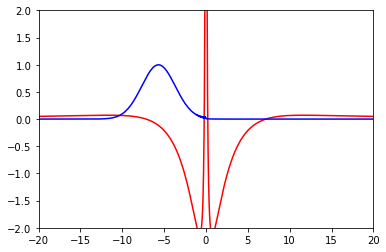

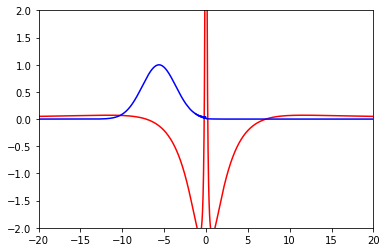

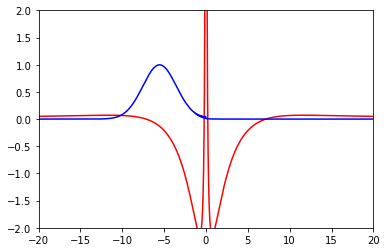

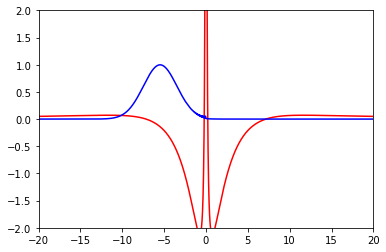

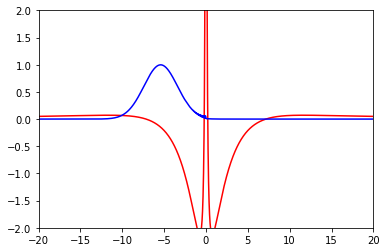

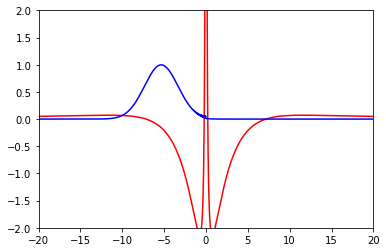

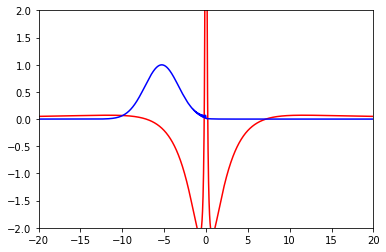

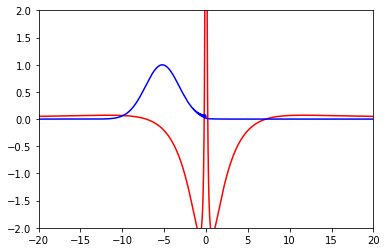

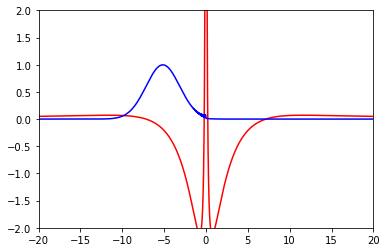

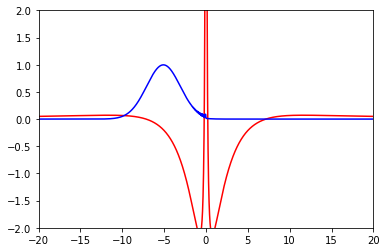

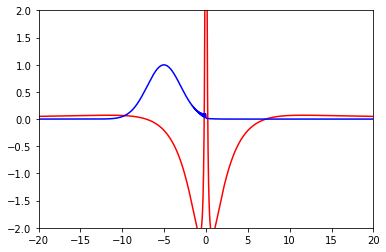

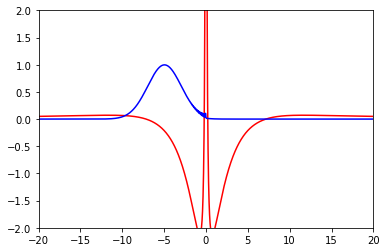

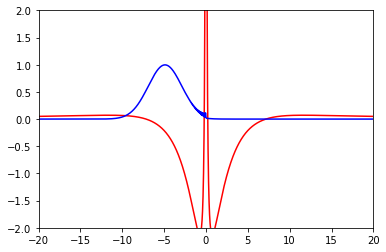

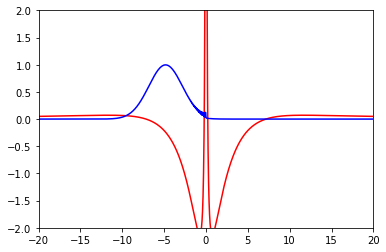

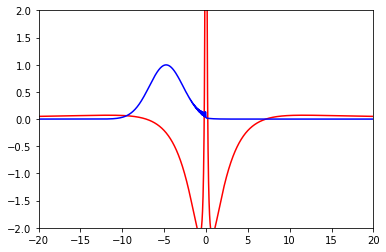

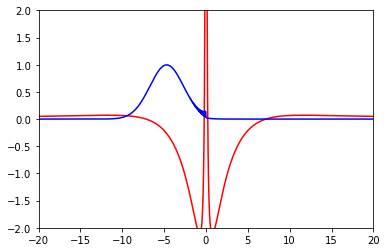

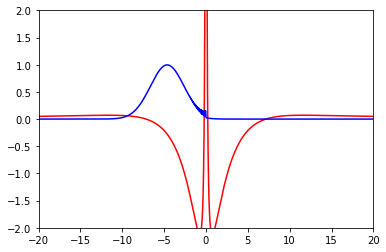

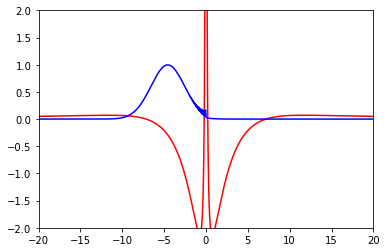

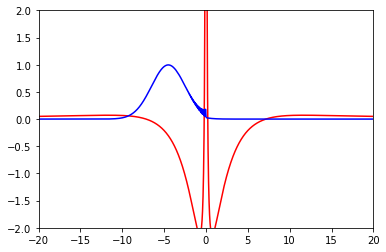

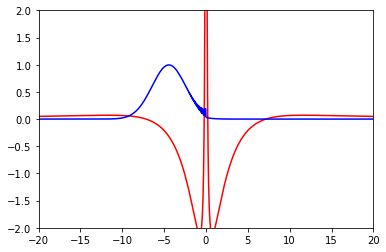

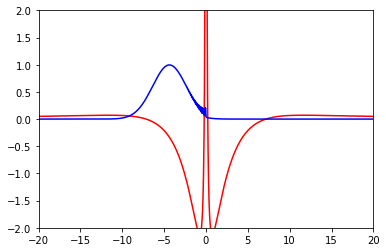

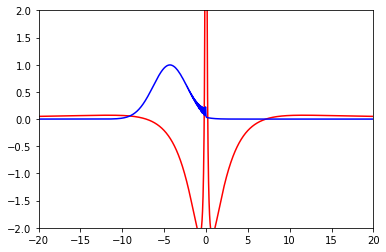

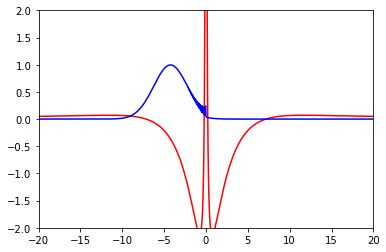

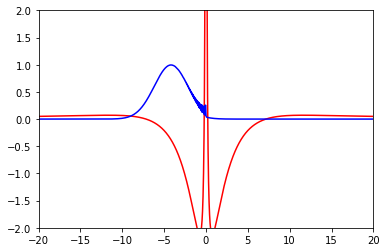

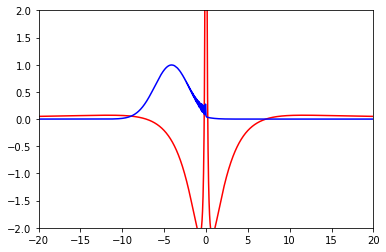

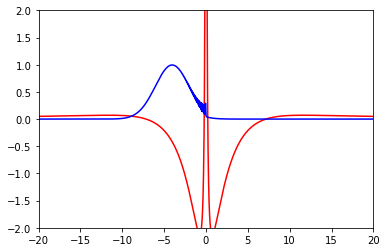

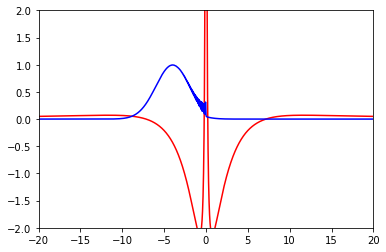

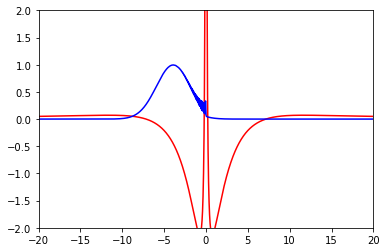

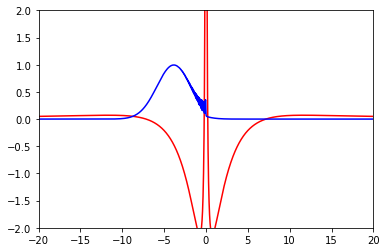

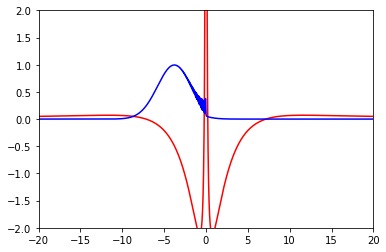

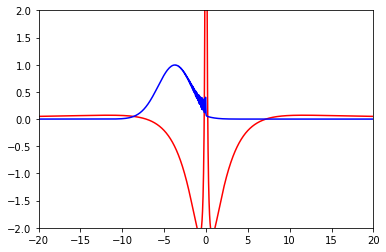

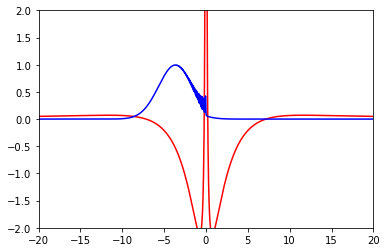

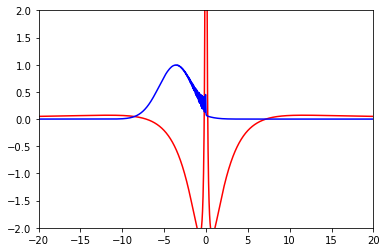

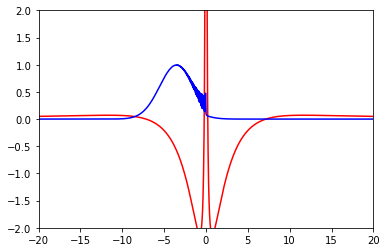

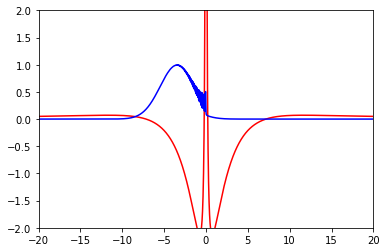

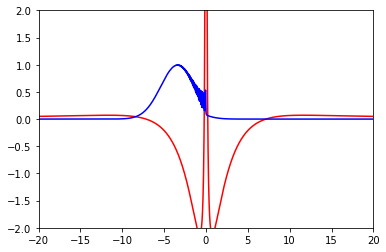

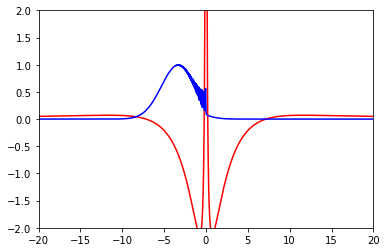

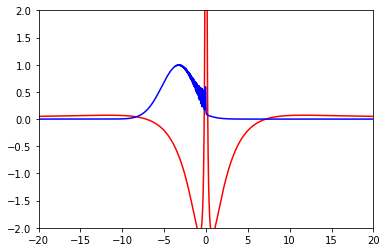

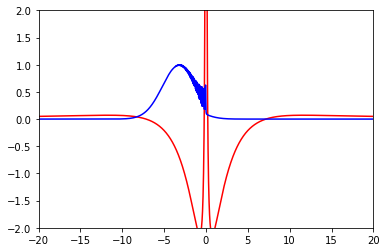

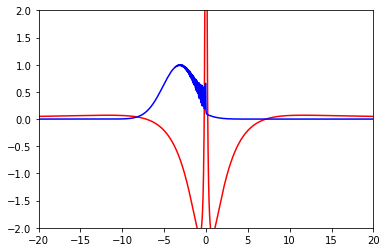

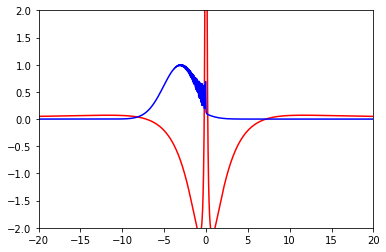

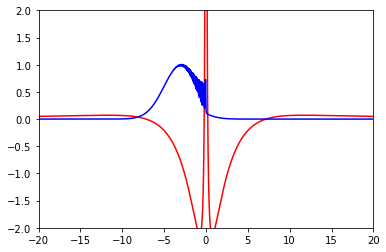

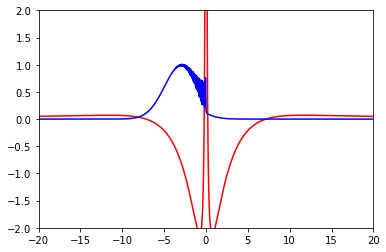

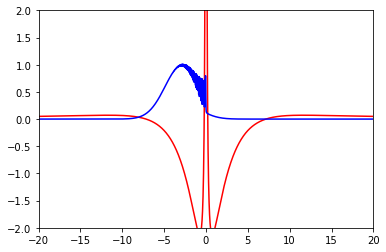

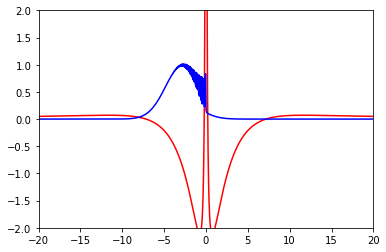

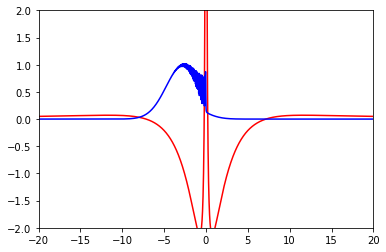

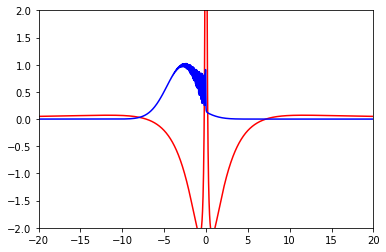

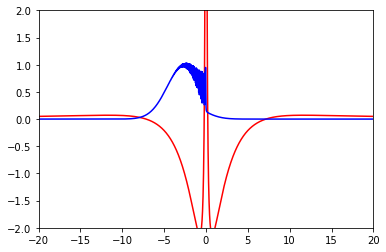

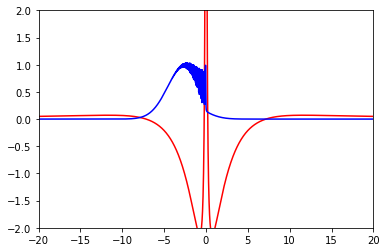

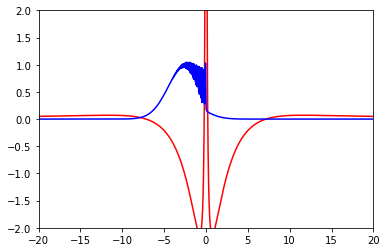

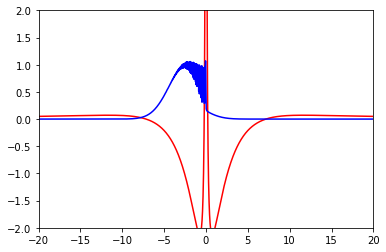

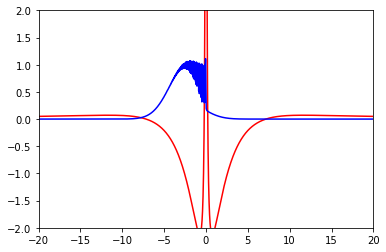

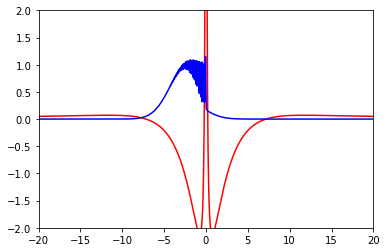

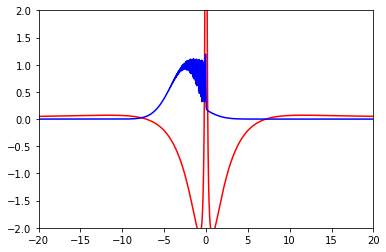

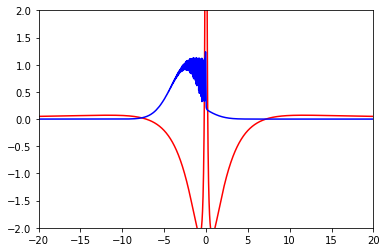

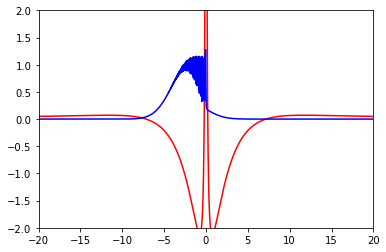

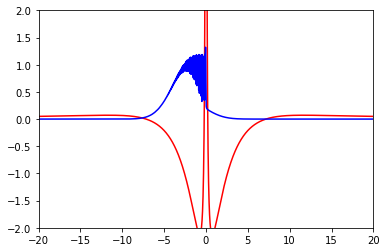

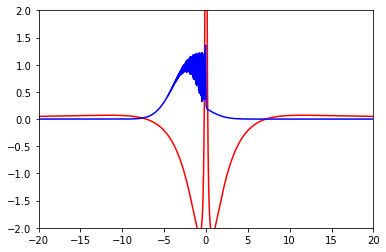

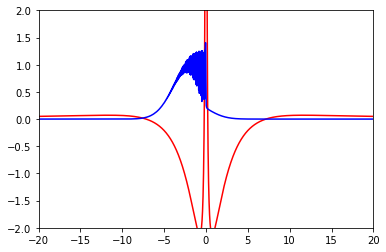

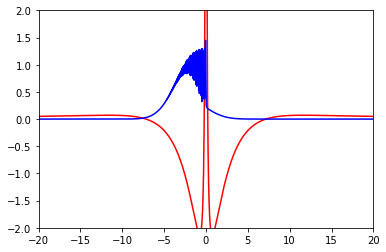

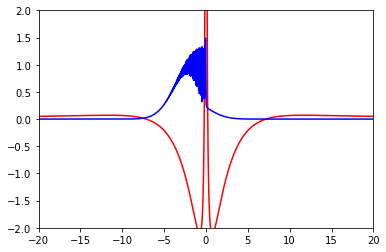

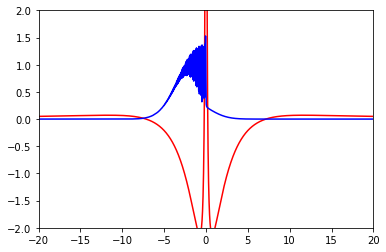

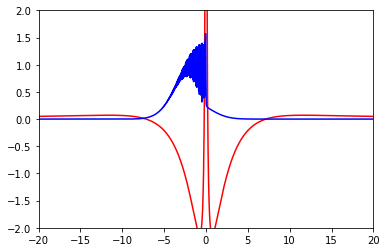

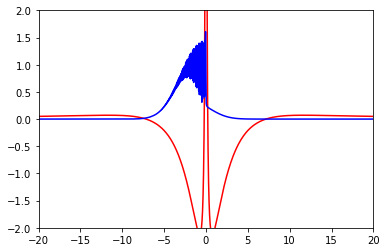

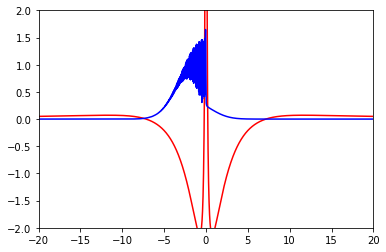

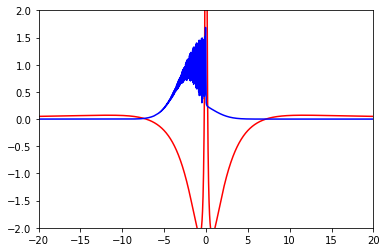

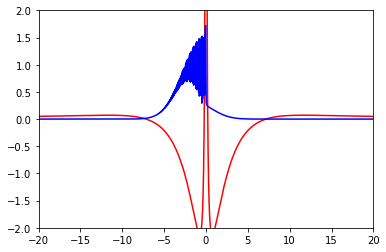

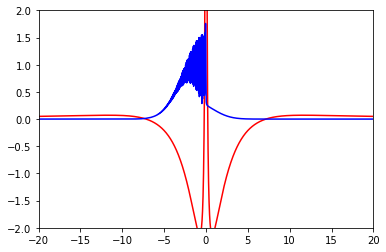

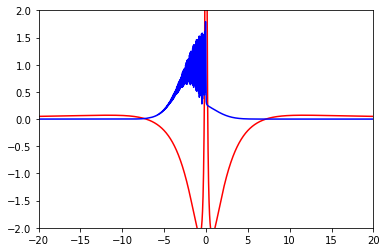

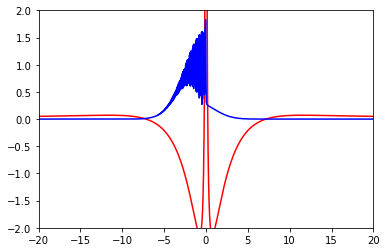

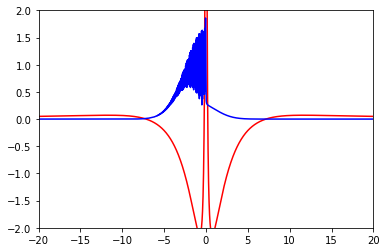

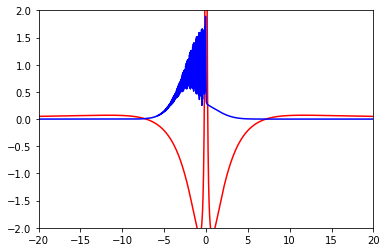

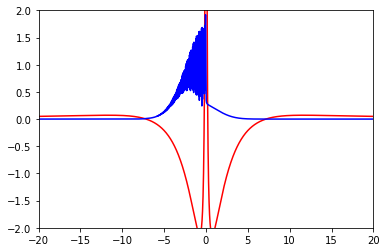

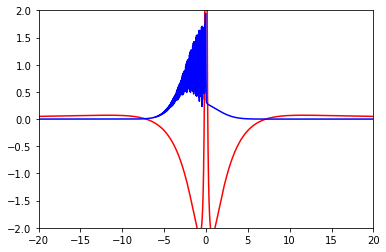

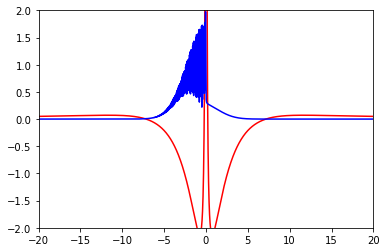

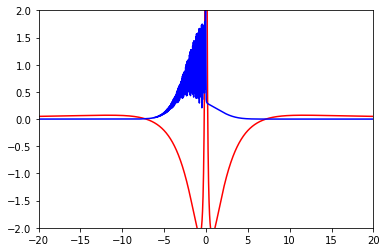

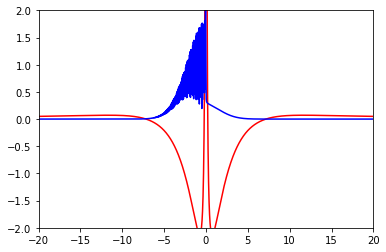

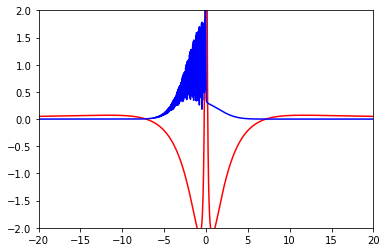

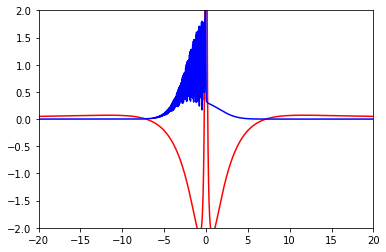

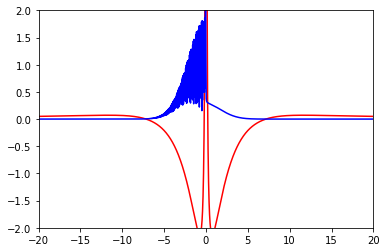

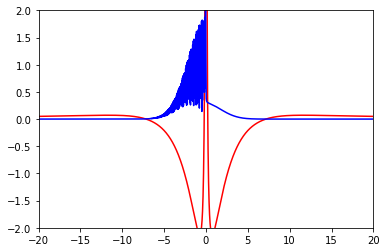

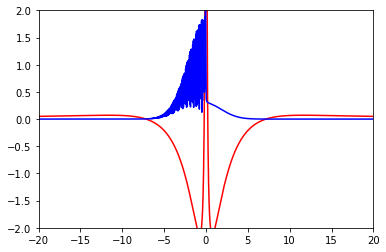

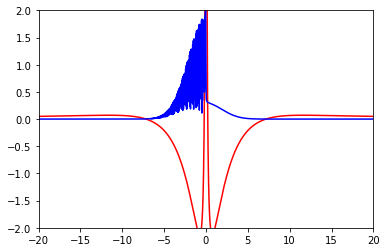

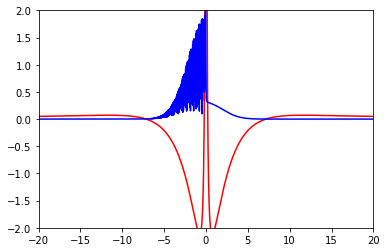

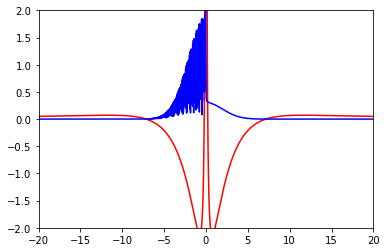

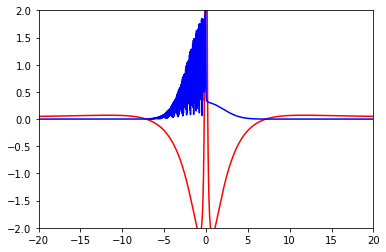

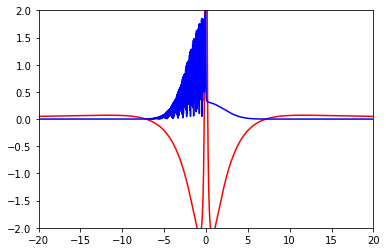

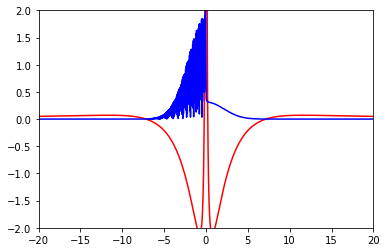

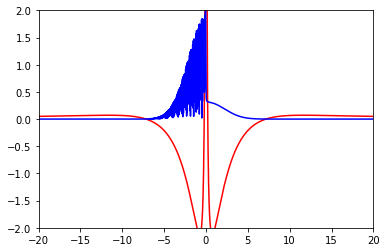

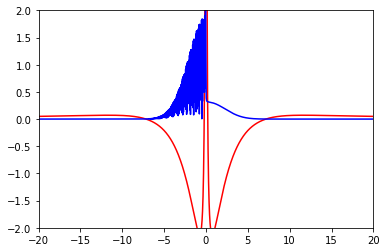

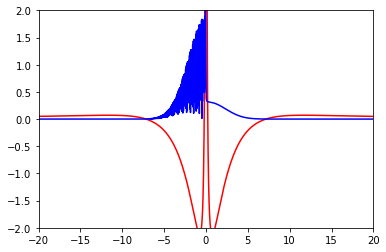

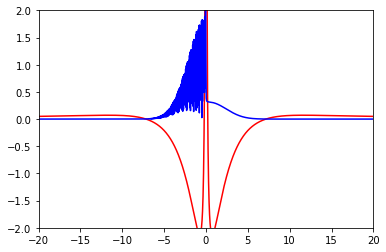

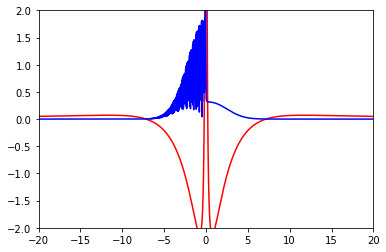

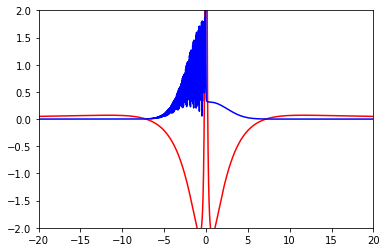

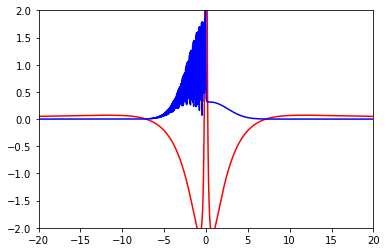

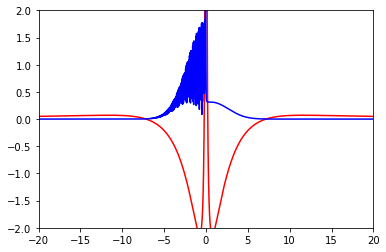

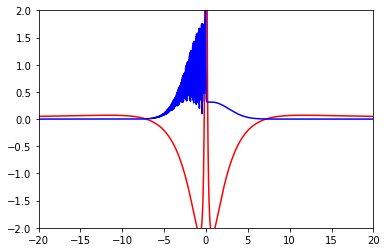

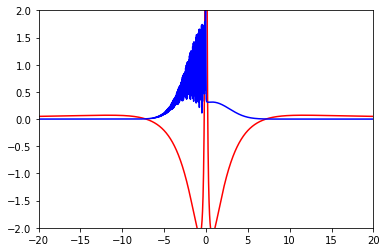

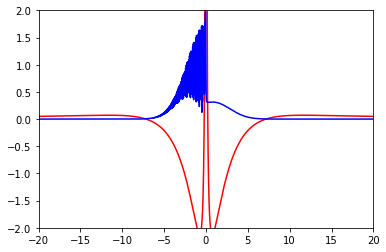

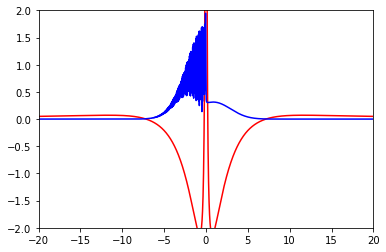

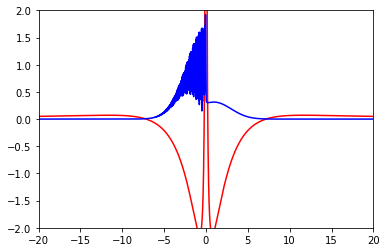

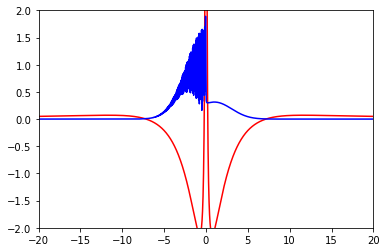

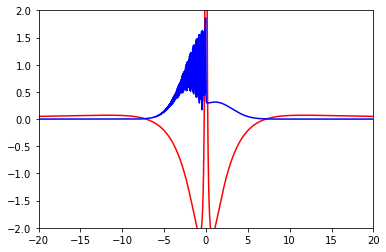

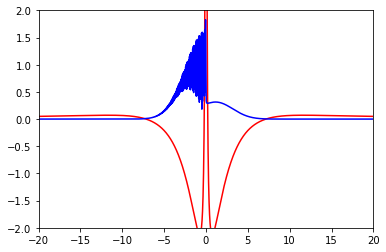

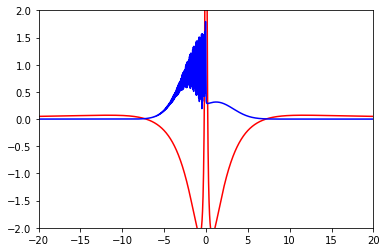

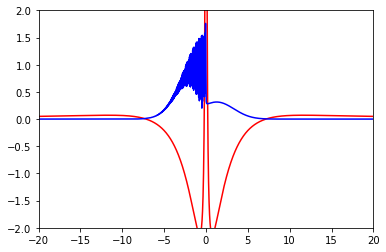

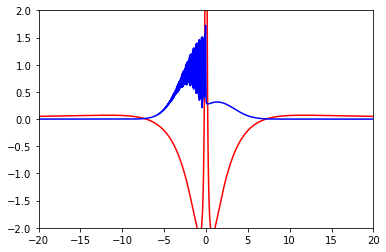

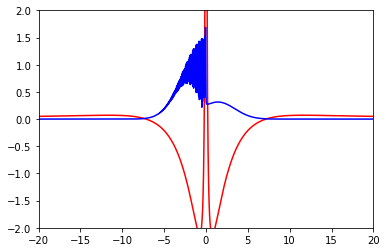

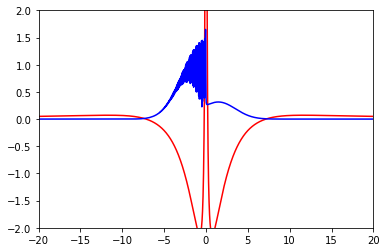

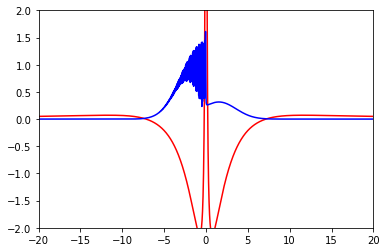

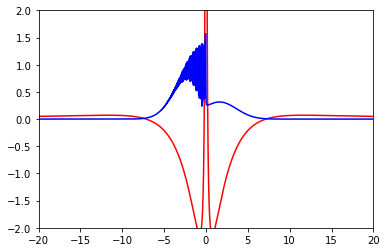

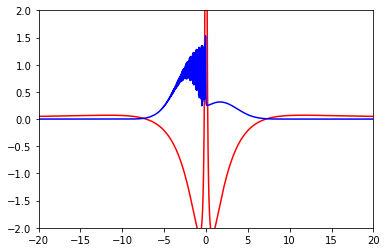

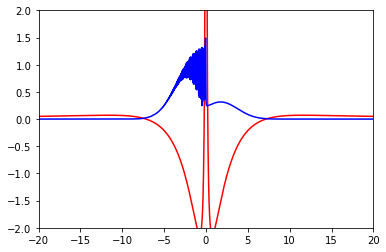

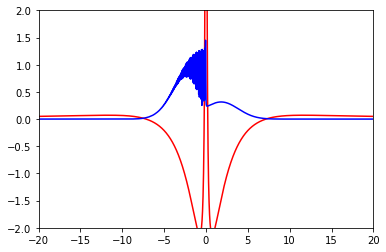

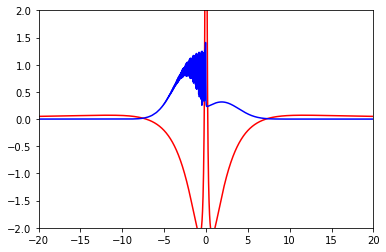

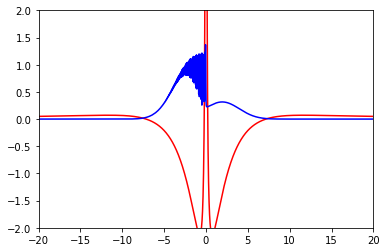

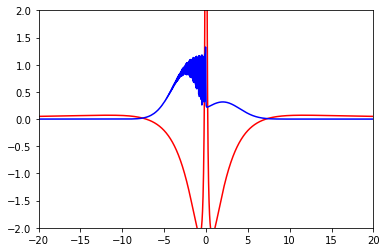

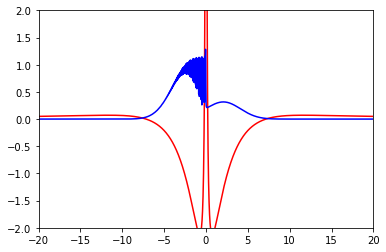

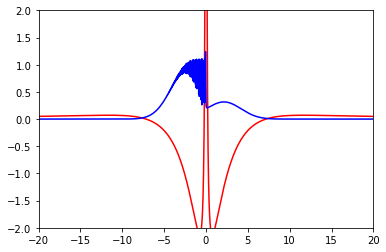

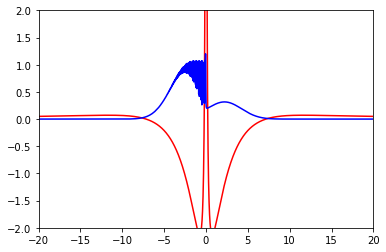

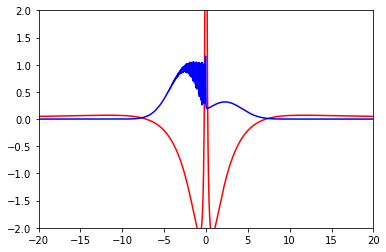

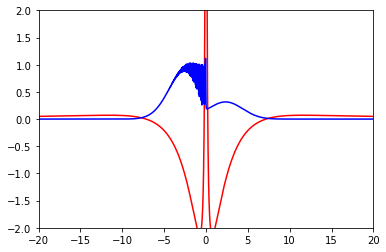

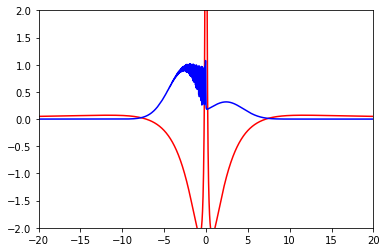

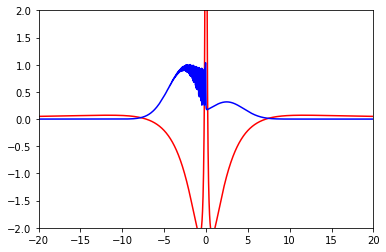

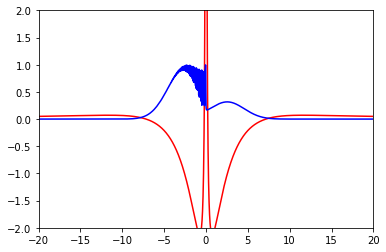

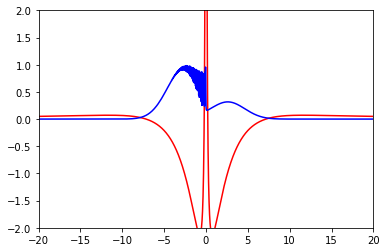

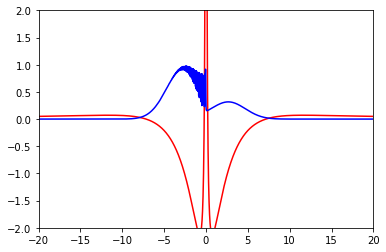

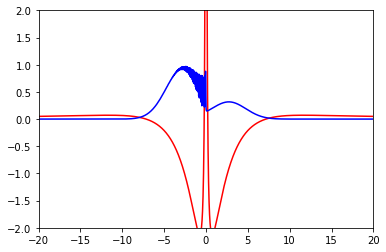

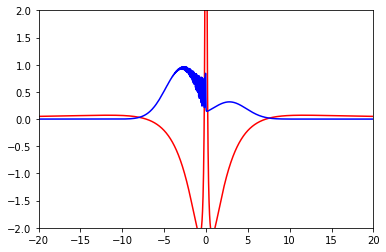

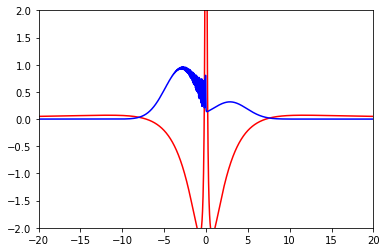

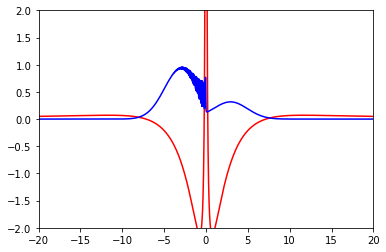

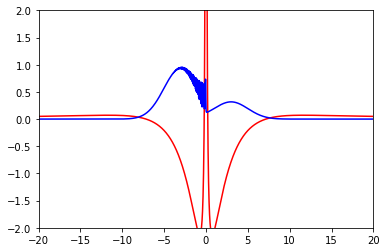

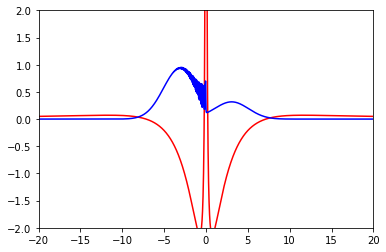

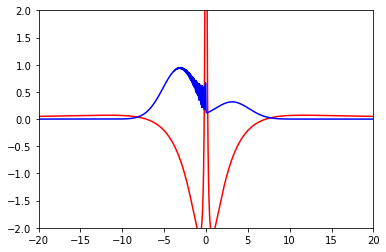

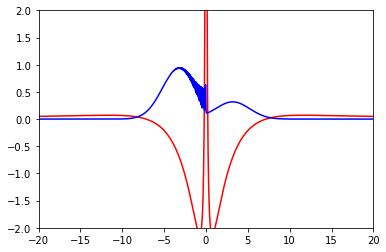

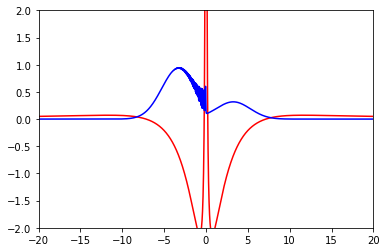

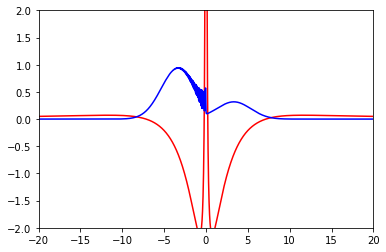

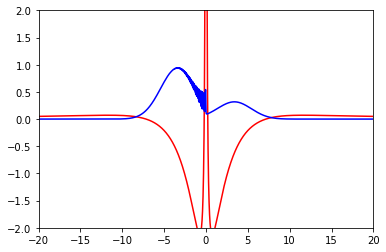

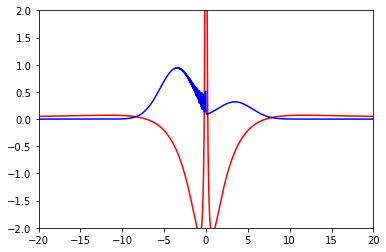

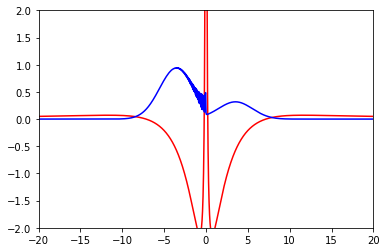

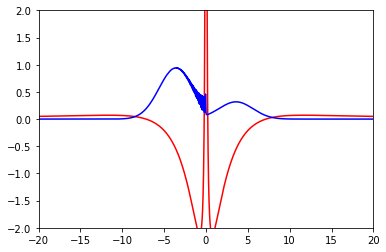

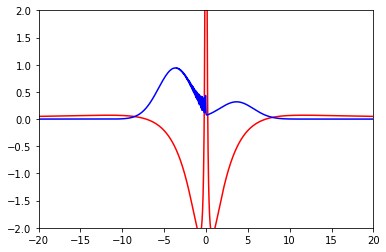

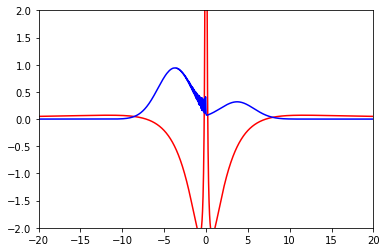

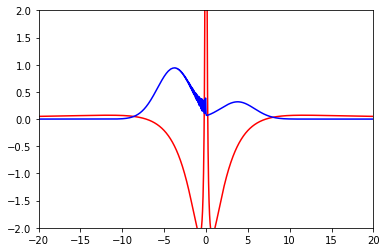

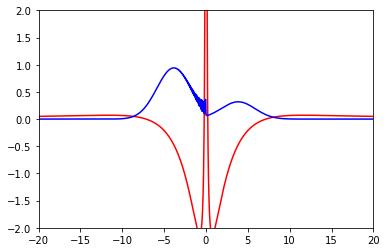

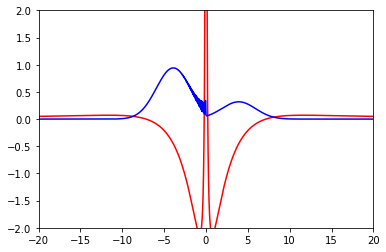

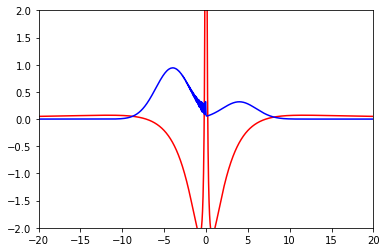

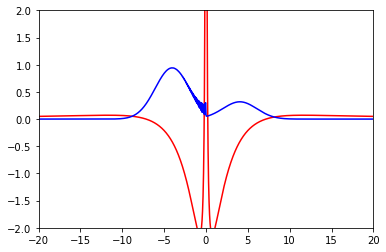

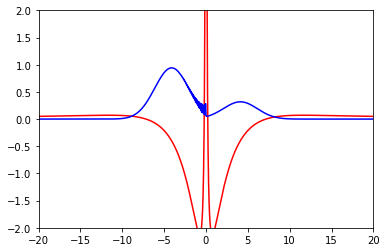

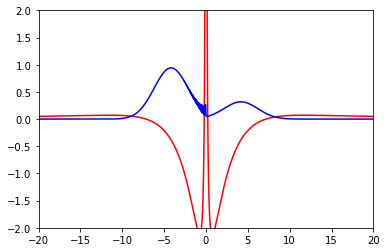

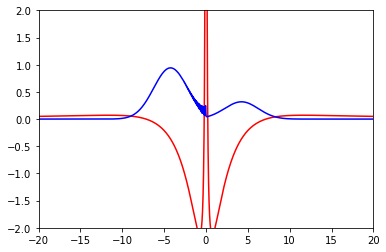

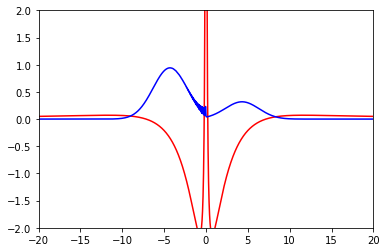

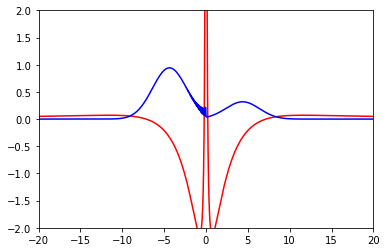

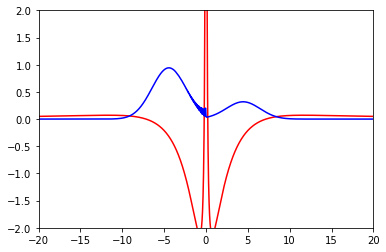

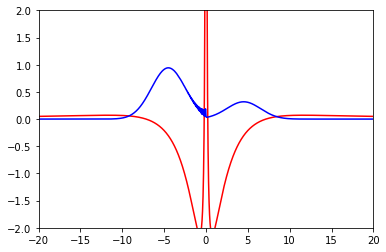

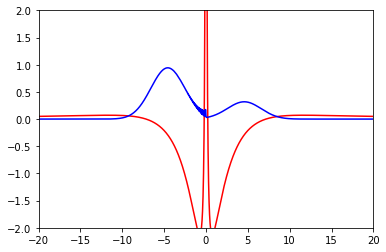

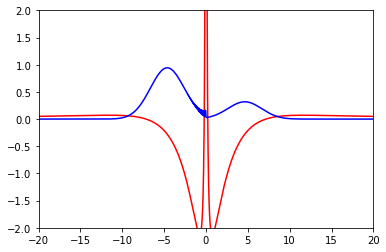

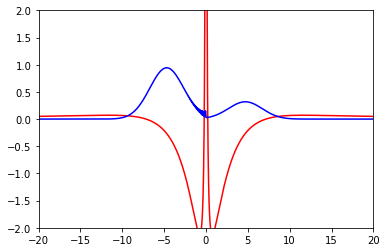

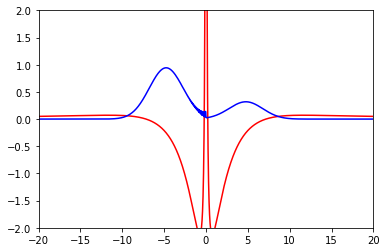

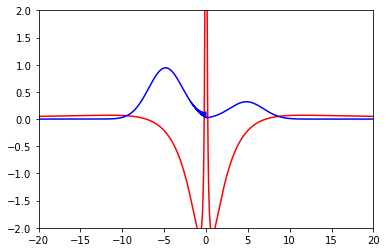

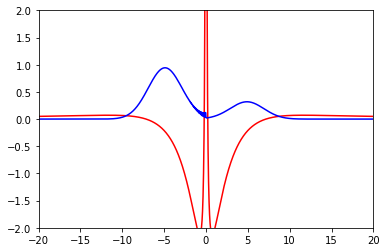

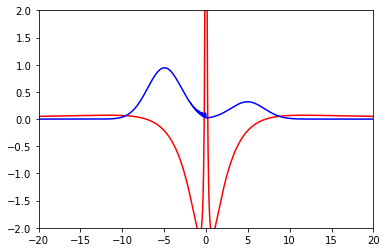

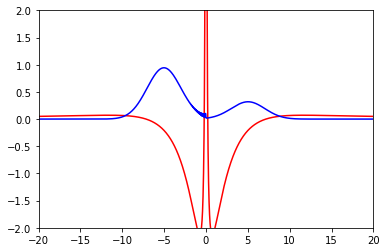

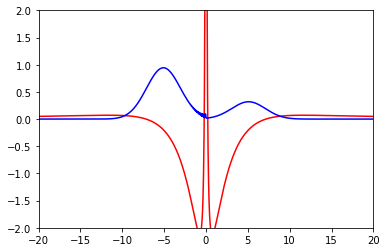

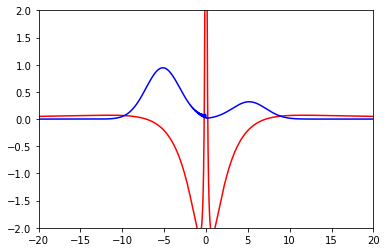

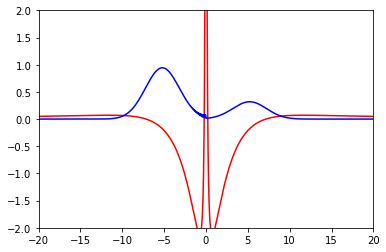

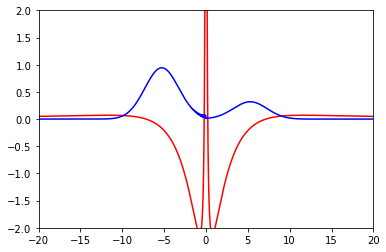

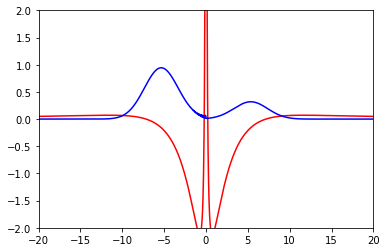

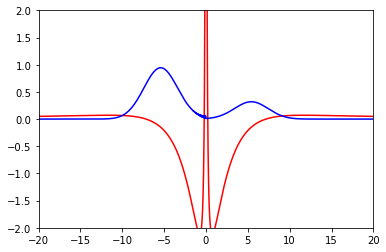

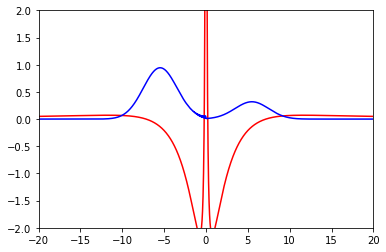

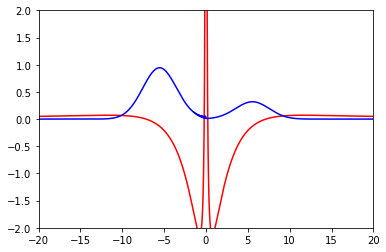

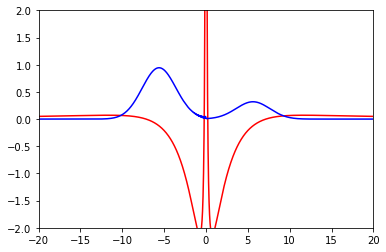

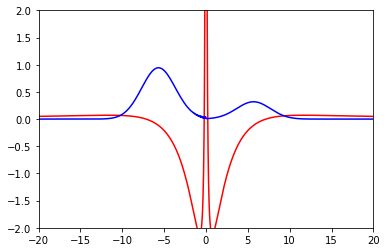

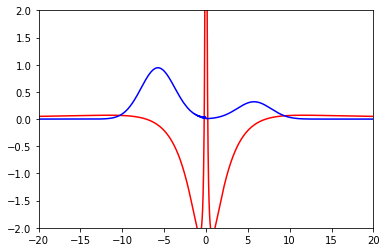

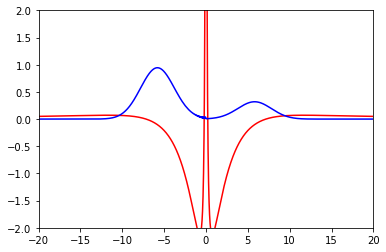

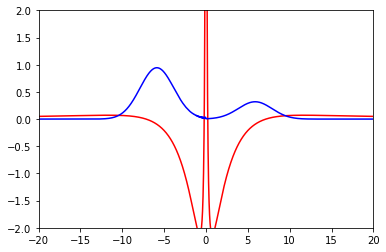

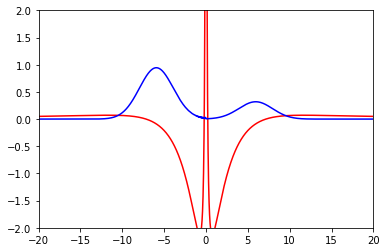

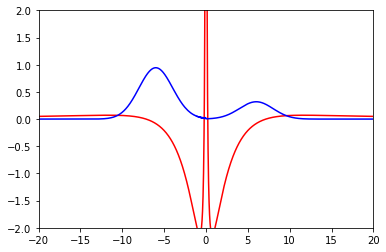

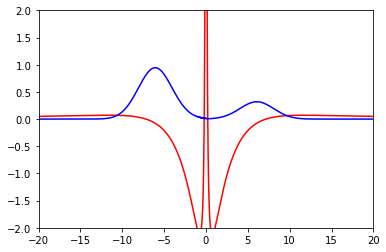

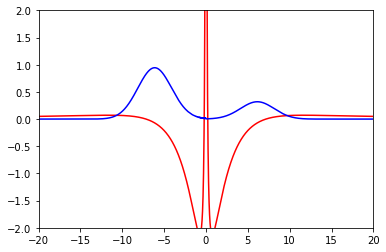

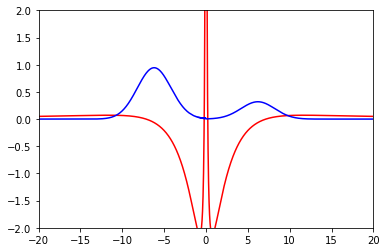

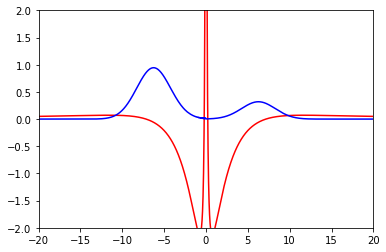

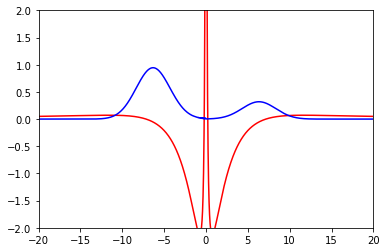

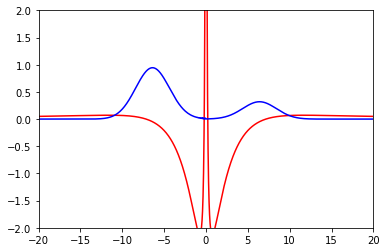

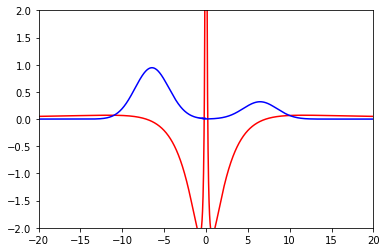

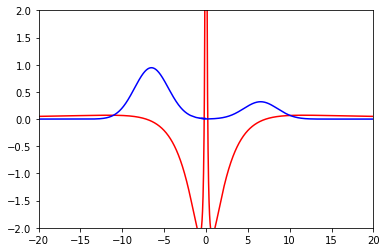

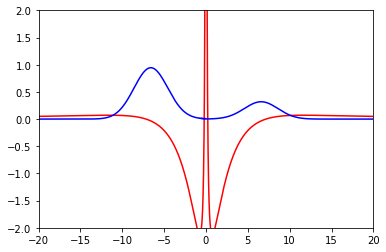

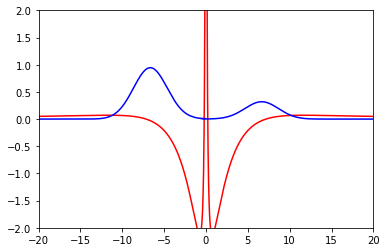

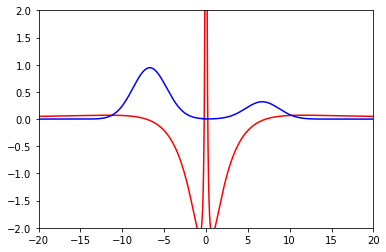

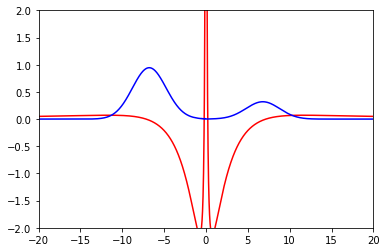

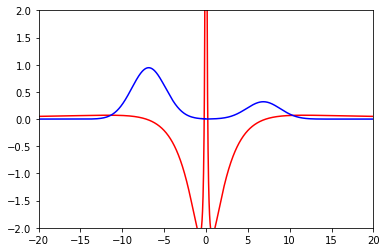

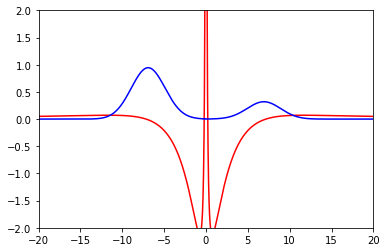

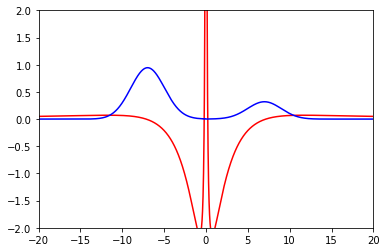

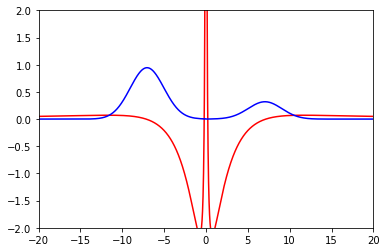

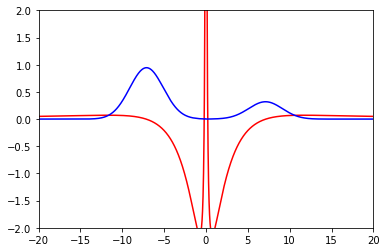

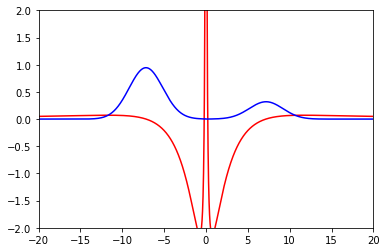

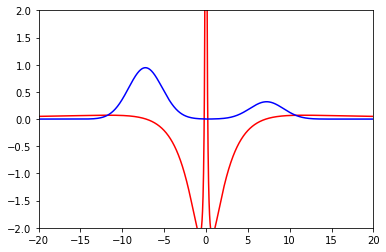

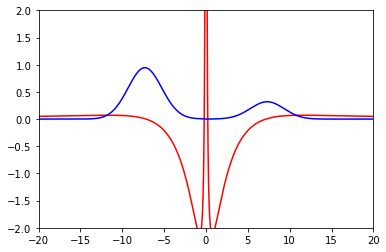

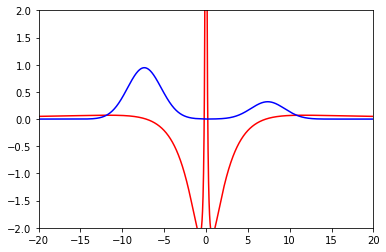

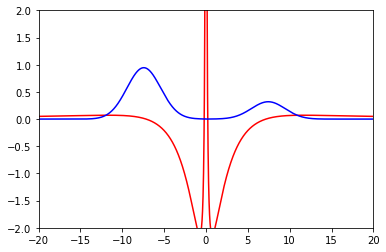

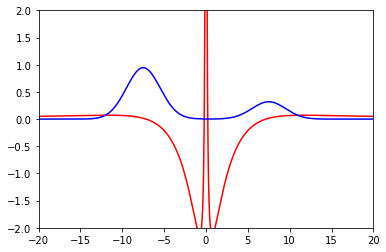

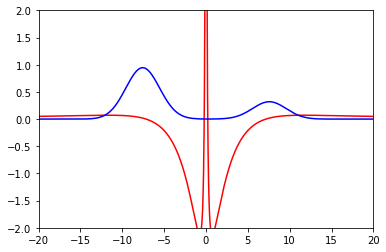

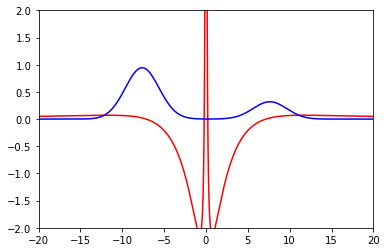

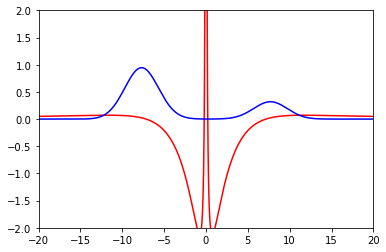

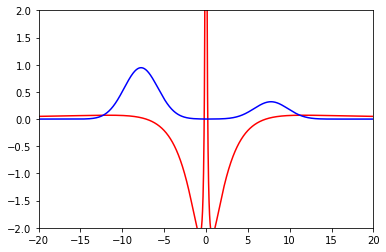

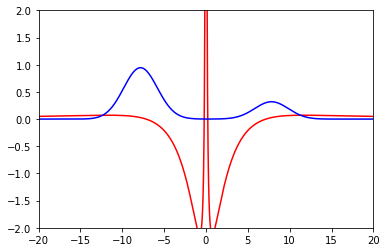

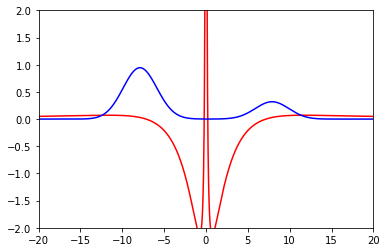

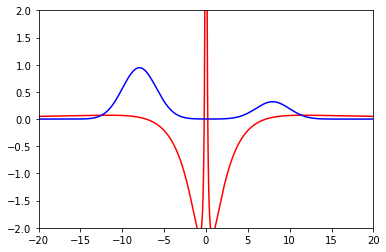

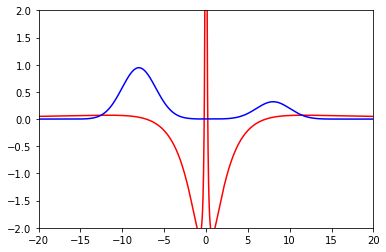

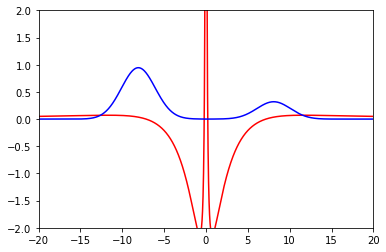

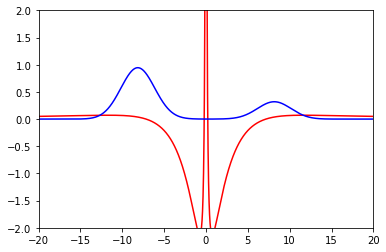

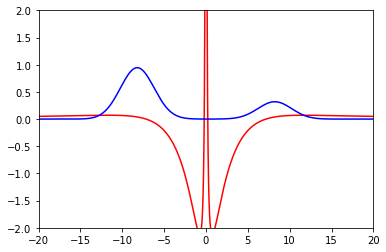

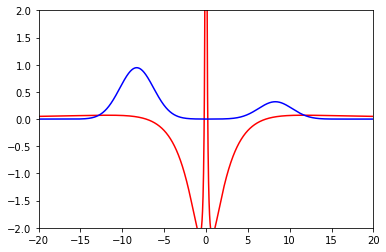

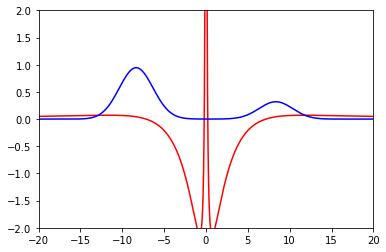

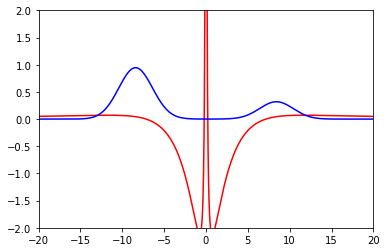

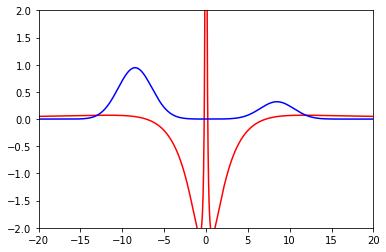

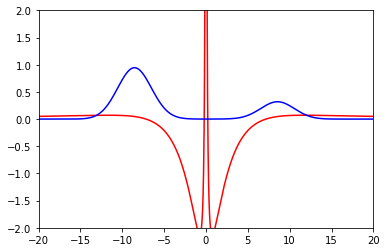

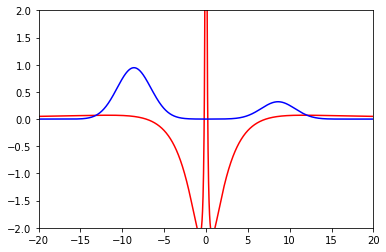

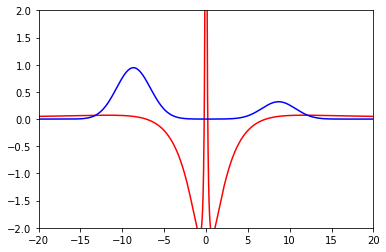

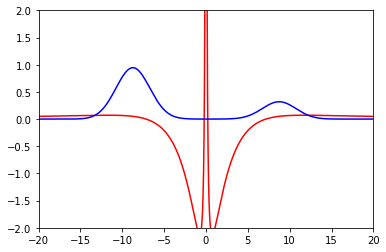

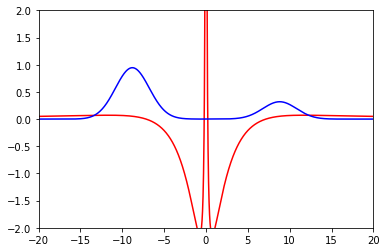

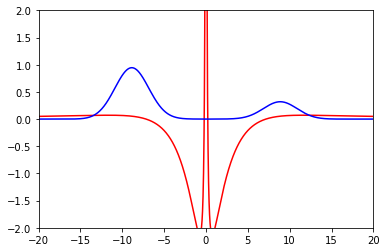

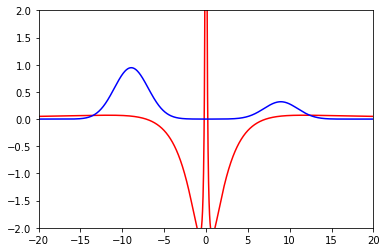

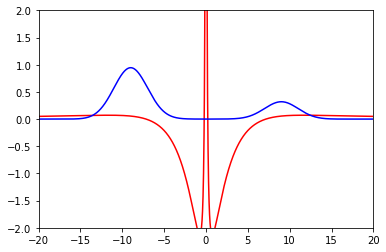

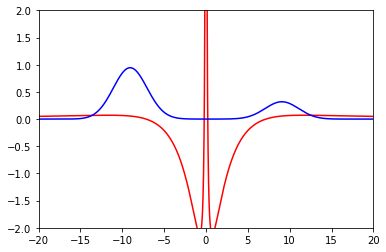

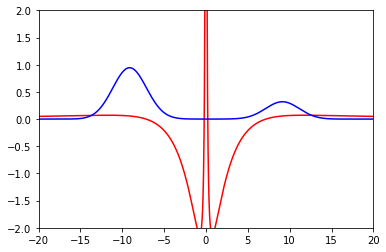

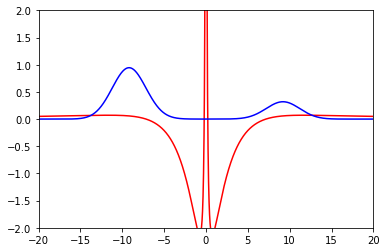

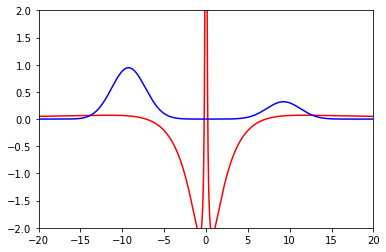

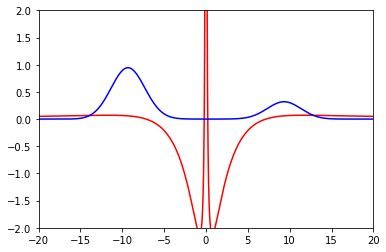

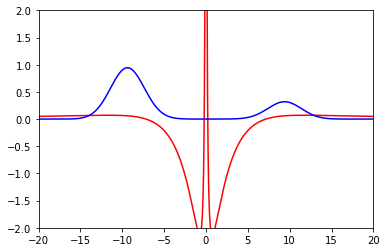

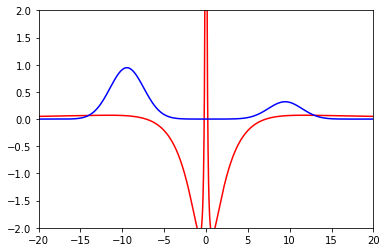

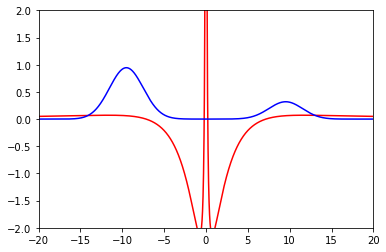

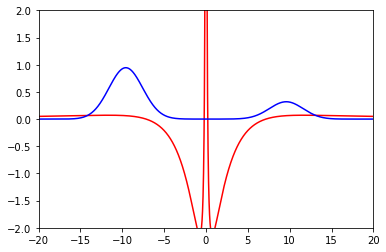

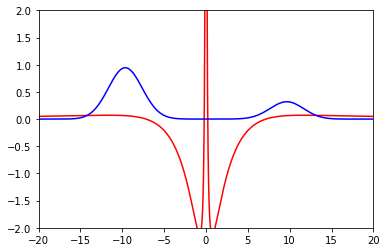

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def V(x):
    return -5*np.exp(-0.5*np.abs(x))+1/(np.abs(x)+0.01)

def update_V(dt, phi, x):
    return np.exp(-1j*dt*V(x))*phi

def update_T(dt, phi, x):
    N = len(x)
    k = np.linspace(-20,20,N)
    psi = np.fft.fft(phi)
    for i in range(0, len(psi)):
        psi[i] = np.exp(-1j*dt*(k[(i+int(0.5*N))%N])**2)*psi[i]
    phi = np.fft.ifft(psi)
    return phi


def solver(phi, x, t_m):
    N_x = len(x)
    dx = x[1]-x[0]
    dt = 0.01
    phi = update_V(dt/2., phi, x)
    phi = update_T(dt, phi, x)
    
    N_max = int(t_m/dt)
    for i in range(N_max):
        phi = update_V(dt, phi, x)
        phi = update_T(dt, phi, x)
        if i%5==0:
            plt.clf()
            plt.plot(x, V(x),'r-')
            plt.plot(x, np.abs(phi),'b-')
            plt.axis([-20,20,-2,2])
            plt.pause(0.02)
    phi = update_V(dt/2., phi, x)
    return phi

#____main_______
x = np.linspace(-20,20,2000)
x0 = -10
sigma = 2
phi0 = np.exp(-0.5*((x-x0)/sigma)**2+1j*x*40)
plt.figure(figsize = (15, 5))
phi = solver(phi0,x,15.0)
plt.show()

<IPython.core.display.Javascript object>


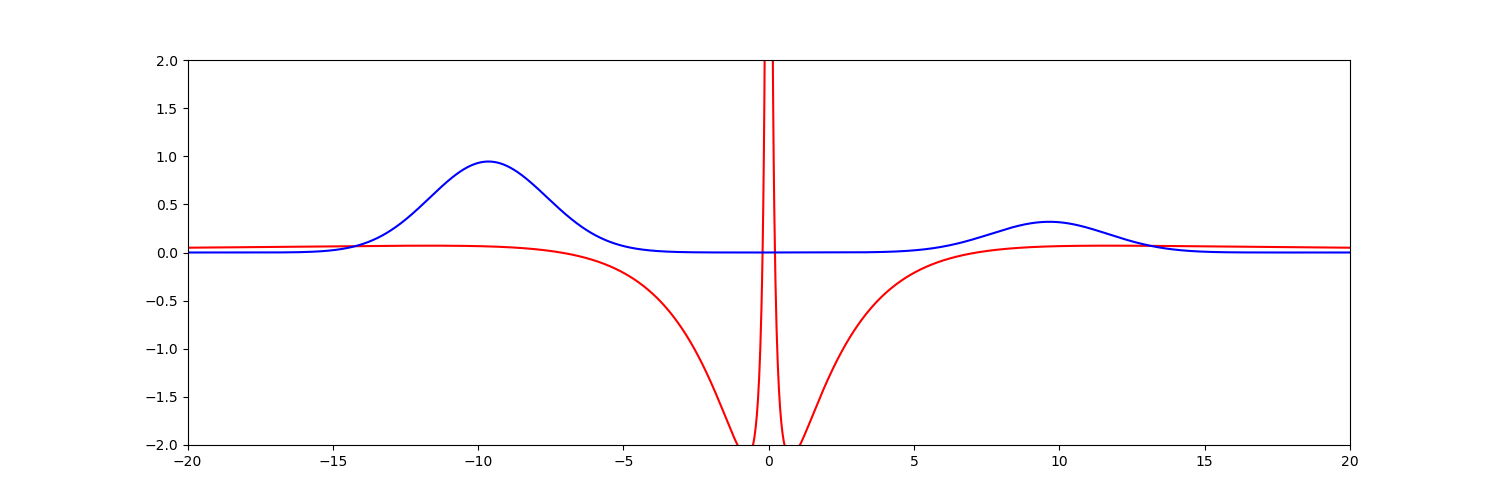

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def V(x):
    return -5*np.exp(-0.5*np.abs(x))+1/(np.abs(x)+0.01)

def update_V(dt, phi, x):
    return np.exp(-1j*dt*V(x))*phi

def update_T(dt, phi, x):
    N = len(x)
    k = np.linspace(-20,20,N)
    psi = np.fft.fft(phi)
    for i in range(0, len(psi)):
        psi[i] = np.exp(-1j*dt*(k[(i+int(0.5*N))%N])**2)*psi[i]
    phi = np.fft.ifft(psi)
    return phi


def solver(phi, x, t_m):
    N_x = len(x)
    dx = x[1]-x[0]
    dt = 0.01
    phi = update_V(dt/2., phi, x)
    phi = update_T(dt, phi, x)
    
    N_max = int(t_m/dt)
    for i in range(N_max):
        phi = update_V(dt, phi, x)
        phi = update_T(dt, phi, x)
        if i%5==0:
            plt.clf()
            plt.plot(x, V(x),'r-')
            plt.plot(x, np.abs(phi),'b-')
            plt.axis([-20,20,-2,2])
            plt.pause(0.02)
    phi = update_V(dt/2., phi, x)
    return phi

#____main_______
x = np.linspace(-20,20,2000)
x0 = -10
sigma = 2
phi0 = np.exp(-0.5*((x-x0)/sigma)**2+1j*x*40)
plt.figure(figsize = (15, 5))
phi = solver(phi0,x,15.0)
plt.show()